# Project 4 - Mc907/Mo651 - Mobile Robotics

### Student:
Luiz Eduardo Cartolano - RA: 183012

### Instructor:
Esther Luna Colombini

### Github Link:
[Project Repository](https://github.com/luizcartolano2/mc907-mobile-robotics)

### Youtube Link:
[Link to Video](https://youtu.be/uqNeEhWo0dA)

### Subject of this Work:
The general objective of this work is to implement a deep learning approach for solve the Visual Odometry problem.

### Goals:
1. Implement and evaluate a Deep VO strategy using images from the [AirSim](https://github.com/microsoft/AirSim) simulator.

In [36]:
import pandas as pd
import glob
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.autograd import Function
from torch.autograd import Variable
from torchvision import models
import torch.optim as optim
import math
from scipy.spatial.transform import Rotation as R
import matplotlib
import matplotlib.pyplot as plt

## Data Pre-Processing

### Clean wrong images

While upload images obtained from the AirSim simulator were noted that some of them had failure, so, we have to clean this data to avoid noise in the dataset.

In [ ]:
for dt in ['1','2','3','4','5','6']:
    path = 'dataset/'+'seq'+dt+'/'
    print("-------------------------------------------")
    print('|    '+path)
    all_images = glob.glob(path+'images'+'/*')
    df_poses = pd.read_csv(path+'poses.csv')[['ImageFile']].values
    for img in df_poses:
        if not (path+'images/'+img) in all_images:
            print('|        '+img[0])
    print("-------------------------------------------")          

### Images

In [53]:
def compute_rgb_mean(image_sequence):
    '''
        Compute the mean over each channel separately over a set of images.
        Parameters
        ----------
        image_sequence  :   np.ndarray
                        Array of shape ``(N, h, w, c)`` or ``(h, w, c)``
    '''
    if image_sequence.ndim == 4:
        _, h, w, c = image_sequence.shape
    if image_sequence.ndim == 3:
        h, w, c = image_sequence.shape
    # compute mean separately for each channel
    # somehow this expression is buggy, so we must do it manually
    # mode = image_sequence.mean((0, 1, 2))
    mean_r = image_sequence[..., 0].mean()
    mean_g = image_sequence[..., 1].mean()
    mean_b = image_sequence[..., 2].mean()
    mean = np.array([mean_r, mean_g, mean_b])
    return mean

def mean_normalize(images_vector):
    '''
        Normalize data to the range -1 to 1
    '''
    out_images = []
    
    N = len(images_vector)
    
    print('|    Mean-normalizing ...')

    mean_accumlator = np.zeros((3,), dtype=np.float32)

    # run over entire dataset to compute mean (fucking inefficient but I have other shit to do)
    for idx in range(N):
        img = images_vector[idx]
        mean_accumlator += compute_rgb_mean(img)

    mean_accumlator /= N
    print(f'|    Mean: {mean_accumlator}')
    
    for idx in range(N):
        img = images_vector[idx]
        out_images.append(img - mean_accumlator)
    
    print('|    Done')
    
    return out_images

In [54]:
def get_image(path,img_size=(256,144)):
    """
        Function to read an image from a given path.
        
        :param: path - image path
        :param: img_size - image size
        
        :return: img - numpy array with the images pixels (converted to grayscale and normalized)
        
    """
    # read image from path
    img = cv2.imread(path)

    # normalize image pixels
    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return img

In [118]:
def load_images(img_dir, img_size=(256,144)):

    """
        Function to coordinate the load of all the images that are going to be used.
        
        :param: img_dir - path to the directory containing the images
        :param: img_size - image size
        
        :return: images_set - numpy array with all images at the set
        
    """
    print("----------------------------------------------------------------------")
    print ("|    Loading images from: ", img_dir)
    # create two empty list that are going to be used for save the images
    images= []
    images_set =[]
    # loop to read all the images of the directory
    for img in glob.glob(img_dir+'/*'):
        images.append(get_image(img,img_size))
    
    images = mean_normalize(images)
    
    # loop on the read images agrupping them two by two
    for i in range(len(images)-1):
        img1 = images[i]
        img2 = images[i+1]

        ret = np.empty((2, img_size[1], img_size[0], 6))
        ret[0, ..., 0:3] = img1
        ret[0, ..., 3:6] = img2
        
        assert (ret[0, ..., :3] == img1).all()
        assert (ret[0, ..., 3:6] == img2).all()
        
        images_set.append(ret)
        
    print("|    Images count : ",len(images_set))

    # reshape the array of all images
    images_set = np.reshape(images_set, (-1, 144, 256, 6))
    print("----------------------------------------------------------------------")

    return images_set

In [119]:
teste = load_images('dataset/seq1/images/')

----------------------------------------------------------------------
|    Loading images from:  dataset/seq1/images/
|    Mean-normalizing ...
|    Mean: [0.3115534  0.29183614 0.27286035]
|    Done
|    Images count :  326
----------------------------------------------------------------------


In [120]:
teste[0].shape

(144, 256, 6)

In [ ]:
teste[]

In [64]:
img1 = get_image('dataset/seq1/images/img__0_1574447279695982000.png')
img2 = get_image('dataset/seq1/images/img__0_1574447263434879000.png')

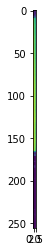

In [122]:
plt.imshow(teste[0][0,...,0:3])

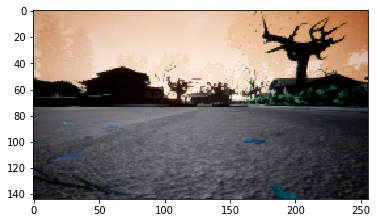

In [67]:
plt.imshow(img2)

In [85]:
stacked = [img1,img2]

In [89]:
ret = np.empty((2, 144, 256, 6))

In [101]:
ret[0, ..., 0:3] = img1
ret[0, ..., 3:6] = img2

In [102]:
ret.shape

(2, 144, 256, 6)

In [103]:
(ret[0, ..., :3] == img1).all()

True

In [104]:
(ret[0, ..., 3:] == img2).all()

True

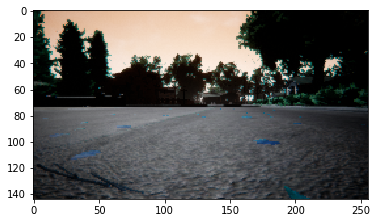

In [106]:
plt.imshow(ret[0,...,0:3])

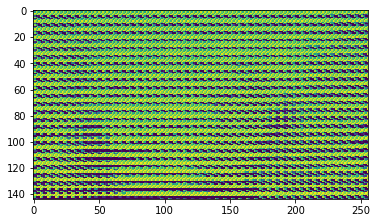

In [61]:
plt.imshow(teste[0][0])

In [57]:
teste.shape

(326, 6, 144, 256)

### Pose

The next three functions are used to the Kitti Dataset poses.

In [ ]:
def isRotationMatrix(R):
    """ 
        Checks if a matrix is a valid rotation matrix referred from 
        https://www.learnopencv.com/rotation-matrix-to-euler-angles/
        
        :param: R - rotation matrix
        
        :return: True or False
        
    """
    # calc the transpose
    Rt = np.transpose(R)

    # check identity
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    
    return n < 1e-6

In [ ]:
def rotationMatrixToEulerAngles(R):
    """ 
        Calculates rotation matrix to euler angles
        referred from https://www.learnopencv.com/rotation-matrix-to-euler-angles
        
        :param: R - rotation matrix
        
        :return: rotation matrix for Euler angles
    """
    assert(isRotationMatrix(R))
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

In [ ]:
def getMatrices(all_poses):
    """
        Function to extract matrices from poses
        
        :param: all_poses - list with all poses from the sequence
        
        :return: all_matrices - list with all matrices obtained from the poses
    """
    all_matrices = []
    for i in range(len(all_poses)):
        #print("I: ",i)
        j = all_poses[i]
        #print("J:   ",j)
        p = np.array([j[3], j[7], j[11]])
        #print("P:   ", p)
        R = np.array([[j[0],j[1],j[2]],
                      [j[4],j[5],j[6]],
                      [j[8],j[9],j[10]]
                     ])
        #print("R:   ", R)
        angles = rotationMatrixToEulerAngles(R)
        #print("Angles: ",angles)
        matrix = np.concatenate((p,angles))
        #print("MATRIX: ", matrix)
        all_matrices.append(matrix)
    return all_matrices

In [ ]:
def load_kitti_images(pose_file):
    poses = []
    poses_set = []

    with open(pose_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            pose = np.fromstring(line, dtype=float, sep=' ')
            poses.append(pose)
    
    poses = getMatrices(poses)
    for i in range(len(poses)-1):
        pose1 = poses[i]
        pose2 = poses[i+1]
        finalpose = np.zeros(pose1)
        poses_set.append(finalpose)

    return poses_set

The next two functions are used for the poses obtained from the AirSim simulator.

In [90]:
def quat_to_euler_angles(quat_matrix):
    # create a scipy object from the quaternion angles
    rot_mat = R.from_quat(quat_matrix)
    # convert the quaternion to euler (in degrees)
    euler_mat = rot_mat.as_euler('yxz', degrees=False)

    #TODO: convert from (-pi,pi) to (0,2pi) ?
    
    return euler_mat

In [91]:
def load_airsim_pose(pose_file):
    #TODO: subtract first pose from all
    
    poses = []
    poses_set = []
    
    df_poses = pd.read_csv(pose_file)
    for index, row in df_poses.iterrows():
        # get the (x,y,z) positions of the camera
        position = np.array([row['POS_X'],row['POS_Y'],row['POS_Z']])
        # get the quaternions angles of the camera
        quat_matrix = np.array([row['Q_X'],row['Q_Y'], row['Q_Z'],row['Q_W']])
        # call the func that convert the quaternions to euler angles
        euler_matrix = quat_to_euler_angles(quat_matrix)
        # concatenate both vectors
        poses.append(np.concatenate((position,euler_matrix)))
        
    for i in range(len(poses)-1):
        pose1 = poses[i]
        pose2 = poses[i+1]

        pose_diff = np.subtract(pose2, pose1)
        pose_diff[4:] = np.arctan2(np.sin(pose_diff[4:]), np.cos(pose_diff[4:]))

        poses_set.append(pose_diff)
        
    return poses_set

In [94]:
def load_poses(pose_file, pose_format='airsim'):
    """
        Function to load the image poses.
        
        :param: pose_file - path to the pose file
        :param: pose_format - where the pose were obtained from (AirSim, VREP, Kitti, etc...)
        
        :return: pose_set - set of the poses for the sequence
    """
    print("----------------------------------------------------------------------")
    print ("|    Pose from: ",pose_file)
    
    if pose_format.lower() == 'kitti':
        poses_set = load_kitti_images(pose_file)
    elif pose_format.lower() == 'airsim':
        poses_set = load_airsim_pose(pose_file)
        
    print("|        Poses count: ",len(poses_set))
    print("----------------------------------------------------------------------")    
    return poses_set

In [95]:
load_poses('dataset/seq1/poses.csv')

----------------------------------------------------------------------
|    Pose from:  dataset/seq1/poses.csv
|        Poses count:  326
----------------------------------------------------------------------


[array([4., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([4., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0.]),
 array([ 0.   

### General

Function that acquire all data that will be used for training.

In [9]:
def VODataLoader(datapath,img_size=(256,144), test=False):
    if test:
        sequences = ['1']
    else:
        sequences = ['1','2','4','5','6']
        
    images_set = []
    odometry_set = []
    
    for sequence in sequences:
        dir_path = os.path.join(datapath,'seq'+sequence)
        image_path = os.path.join(dir_path,'images')
        pose_path = os.path.join(dir_path,'poses.csv')
        print("-----------------------------------------------------------------------")
        print("|Load from: ", dir_path)
        images_set.append(torch.FloatTensor(load_images(image_path,img_size)))
        odometry_set.append(torch.FloatTensor(load_poses(pose_path, 'AirSim')))
        print("-----------------------------------------------------------------------")
    
    print("---------------------------------------------------")
    print("|   Total Images: ", len(images_set))
    print("|   Total Odometry: ", len(odometry_set))
    print("---------------------------------------------------")    
    return images_set, odometry_set

In [10]:
X,y = VODataLoader(datapath='dataset', test=False)

-----------------------------------------------------------------------
|Load from:  dataset/seq1
----------------------------------------------------------------------
|    Loading images from:  dataset/seq1/images
|    Images count :  326
----------------------------------------------------------------------
----------------------------------------------------------------------
|    Pose from:  dataset/seq1/poses.csv
|        Poses count:  326
----------------------------------------------------------------------
-----------------------------------------------------------------------
-----------------------------------------------------------------------
|Load from:  dataset/seq2
----------------------------------------------------------------------
|    Loading images from:  dataset/seq2/images
|    Images count :  283
----------------------------------------------------------------------
----------------------------------------------------------------------
|    Pose from:  dataset

## Data Acquire

Converting lists containing tensors to tensors as per the batchsize (10)

In [11]:
X_train = [item for x in X for item in x]
Y_train = [item for a in y for item in a]

Some info about the training data

In [12]:
print("---------------------------------")
print("Details of X :")
print(type(X_train)) 
print(type(X_train[0]))
print(len(X_train)) 
print(X_train[0].size())
print("---------------------------------")
print("Details of y :")
print(type(Y_train))
print(type(Y_train[0]))
print(len(Y_train))
print(Y_train[0].size())
print("---------------------------------")

---------------------------------
Details of X :
<class 'list'>
<class 'torch.Tensor'>
1306
torch.Size([6, 144, 256])
---------------------------------
Details of y :
<class 'list'>
<class 'torch.Tensor'>
1306
torch.Size([6])
---------------------------------


In [13]:
X_stack = torch.stack(X_train)

In [14]:
y_stack = torch.stack(Y_train)

In [15]:
X_batch = X_stack.view(-1,1,6,144,256)
y_batch = y_stack.view(-1,1,6)

In [16]:
print("Details of X :")
print(X_batch.size())
print("Details of y :")
print(y_batch.size())

Details of X :
torch.Size([1306, 1, 6, 144, 256])
Details of y :
torch.Size([1306, 1, 6])


## Defining DeepVO model

In [17]:
class DeepVONet(nn.Module):
    def __init__(self):
        super(DeepVONet, self).__init__()

        self.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)) #6 64
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d (64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d (128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)
        self.conv3_1 = nn.Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d (256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.conv4_1 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.conv5_1 = nn.Conv2d (512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv6 = nn.Conv2d (512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.lstm1 = nn.LSTMCell(2*6*1024, 100)
        self.lstm2 = nn.LSTMCell(100, 100)
        self.fc = nn.Linear(in_features=100, out_features=6)

        self.reset_hidden_states()

    def reset_hidden_states(self, size=1, zero=True):
        if zero == True:
            self.hx1 = Variable(torch.zeros(size, 100))
            self.cx1 = Variable(torch.zeros(size, 100))
            self.hx2 = Variable(torch.zeros(size, 100))
            self.cx2 = Variable(torch.zeros(size, 100))
        else:
            self.hx1 = Variable(self.hx1.data)
            self.cx1 = Variable(self.cx1.data)
            self.hx2 = Variable(self.hx2.data)
            self.cx2 = Variable(self.cx2.data)

        if next(self.parameters()).is_cuda == True:
            self.hx1 = self.hx1.cuda()
            self.cx1 = self.cx1.cuda()
            self.hx2 = self.hx2.cuda()
            self.cx2 = self.cx2.cuda()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv4_1(x)
        x = self.relu4_1(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv5_1(x)
        x = self.relu5_1(x)
        x = self.conv6(x)
        # print(x.size())
        x = x.view(x.size(0), 2 * 6 * 1024)
        #print(x.size())
        self.hx1, self.cx1 = self.lstm1(x, (self.hx1, self.cx1))
        x = self.hx1
        self.hx2, self.cx2 = self.lstm2(x, (self.hx2, self.cx2))
        x = self.hx2
        #print(x.size())
        x = self.fc(x)
        return x


Defines the training function

In [18]:
def training_model(model, train_num, X, y, epoch_num=25):
    start_time = time.time()
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        print("Epoch : ", epoch+1)
        for i in range(train_num):
            print("    Train num :", i+1)
            inputs = X[i]
            print("        Input Size: {}".format(inputs.size()))
            labels = y[i]
            print("        Labels: ",labels)
            
            model.zero_grad()
            model.reset_hidden_states()

            outputs = model(inputs)
            print("        Outputs: ",outputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('    Epoch : %d Loss: %.3f' %(epoch+1, running_loss/train_num))


    print('Finished Training')
    print ("Time taken in Training {0}".format((time.time() - start_time)))

In [19]:
# creating model
model = DeepVONet()
print(model)

DeepVONet(
  (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (relu3): ReLU(inplace=True)
  (conv3_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (conv4_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4_1): ReLU(inplace=True)
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5_1): ReLU(inplace=True)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm1): LSTMCell(12288, 10

In [20]:
# defining loss and optimizer to be used 
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=0.5)

In [ ]:
for parameter in model.parameters():
     print(len(parameter))

## Training Model

First we load the pretrained weight of FlowNet ( CNN part ).

In [ ]:
pre_trained = torch.load('flownets_EPE1.951.pth.tar',map_location=torch.device('cpu'))

In [ ]:
model_dict = model.state_dict()

In [ ]:
model_dict['conv1.weight'] = pre_trained['state_dict']['conv1.0.weight']
model_dict['conv1.bias'] = pre_trained['state_dict']['conv1.0.bias']
model_dict['conv2.weight'] = pre_trained['state_dict']['conv2.0.weight']
model_dict['conv2.bias'] = pre_trained['state_dict']['conv2.0.bias']
model_dict['conv3.weight'] = pre_trained['state_dict']['conv3.0.weight']
model_dict['conv3.bias'] = pre_trained['state_dict']['conv3.0.bias']
model_dict['conv4.weight'] = pre_trained['state_dict']['conv4.0.weight']
model_dict['conv4.bias'] = pre_trained['state_dict']['conv4.0.bias']
model_dict['conv4_1.weight'] = pre_trained['state_dict']['conv4_1.0.weight']
model_dict['conv4_1.bias'] = pre_trained['state_dict']['conv4_1.0.bias']
model_dict['conv5.weight'] = pre_trained['state_dict']['conv5.0.weight']
model_dict['conv5.bias'] = pre_trained['state_dict']['conv5.0.bias']
model_dict['conv5_1.weight'] = pre_trained['state_dict']['conv5_1.0.weight']
model_dict['conv5_1.bias'] = pre_trained['state_dict']['conv5_1.0.bias']
model_dict['conv6.weight'] = pre_trained['state_dict']['conv6.0.weight']
model_dict['conv6.bias'] = pre_trained['state_dict']['conv6.0.bias']

In [ ]:
model.load_state_dict(model_dict)

Agora a gnt chora hehe

In [21]:
training_model(model,1306,X_batch,y_batch,10)

Epoch :  1
    Train num : 1
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0481,  0.0425, -0.0448, -0.0239,  0.0862, -0.0590]],
       grad_fn=<AddmmBackward>)
    Train num : 2
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0496,  0.0424, -0.0447, -0.0239,  0.0861, -0.0589]],
       grad_fn=<AddmmBackward>)
    Train num : 3
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0517,  0.0424, -0.0446, -0.0239,  0.0860, -0.0588]],
       grad_fn=<AddmmBackward>)
    Train num : 4
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0542,  0.0423, -0.0446, -0.0238,  0.0859, -0.0587]],
       grad_fn=<AddmmBackward>)
    Train num : 5
        Input Size: torch.Size([1, 

    Train num : 36
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0813,  0.0396, -0.0422, -0.0227,  0.0816, -0.0555]],
       grad_fn=<AddmmBackward>)
    Train num : 37
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0812,  0.0395, -0.0421, -0.0226,  0.0814, -0.0554]],
       grad_fn=<AddmmBackward>)
    Train num : 38
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0810,  0.0394, -0.0421, -0.0226,  0.0813, -0.0553]],
       grad_fn=<AddmmBackward>)
    Train num : 39
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0808,  0.0393, -0.0420, -0.0226,  0.0812, -0.0552]],
       grad_fn=<AddmmBackward>)
    Train num : 40
        Input Size: torch.Size([1, 6, 144

    Train num : 69
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.0843,  0.0363, -0.0401, -0.0214,  0.0771, -0.0523]],
       grad_fn=<AddmmBackward>)
    Train num : 70
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0841,  0.0363, -0.0400, -0.0214,  0.0769, -0.0522]],
       grad_fn=<AddmmBackward>)
    Train num : 71
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0839,  0.0362, -0.0400, -0.0213,  0.0768, -0.0521]],
       grad_fn=<AddmmBackward>)
    Train num : 72
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.0837,  0.0361, -0.0399, -0.0213,  0.0767, -0.0521]],
       grad_fn=<AddmmBackward>)


    Train num : 102
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0866,  0.0310, -0.0381, -0.0202,  0.0729, -0.0494]],
       grad_fn=<AddmmBackward>)
    Train num : 103
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.0864,  0.0309, -0.0380, -0.0202,  0.0727, -0.0493]],
       grad_fn=<AddmmBackward>)
    Train num : 104
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.0862,  0.0309, -0.0380, -0.0201,  0.0726, -0.0492]],
       grad_fn=<AddmmBackward>)
    Train num : 105
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.4641, -2.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0860,  0.0308, -0.0379, -0.0201,  0.0725, -0.0491]]

    Train num : 135
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.0853,  0.0257, -0.0362, -0.0190,  0.0688, -0.0466]],
       grad_fn=<AddmmBackward>)
    Train num : 136
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.0852,  0.0256, -0.0361, -0.0190,  0.0686, -0.0465]],
       grad_fn=<AddmmBackward>)
    Train num : 137
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0850,  0.0256, -0.0361, -0.0190,  0.0685, -0.0465]],
       grad_fn=<AddmmBackward>)
    Train num : 138
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0848,  0.0255, -0.0360, -0.0190,  0.0684, -0.0464]],
       grad_fn=<AddmmBackwar

    Train num : 168
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.0809,  0.0218, -0.0344, -0.0180,  0.0649, -0.0440]],
       grad_fn=<AddmmBackward>)
    Train num : 169
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 0.0808,  0.0216, -0.0343, -0.0179,  0.0648, -0.0439]],
       grad_fn=<AddmmBackward>)
    Train num : 170
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0807,  0.0215, -0.0343, -0.0179,  0.0647, -0.0439]],
       grad_fn=<AddmmBackward>)
    Train num : 171
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 0.0806,  0.0214, -0.0342, -0.0179,  0.0646, -0.0438]]

    Train num : 200
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1396, -3.9976,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0736,  0.0129, -0.0328, -0.0192,  0.0613, -0.0438]],
       grad_fn=<AddmmBackward>)
    Train num : 201
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.0734,  0.0109, -0.0327, -0.0191,  0.0612, -0.0438]],
       grad_fn=<AddmmBackward>)
    Train num : 202
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  3.1416, -0.0174,  3.1416]])
        Outputs:  tensor([[ 0.0732,  0.0099, -0.0327, -0.0191,  0.0611, -0.0437]],
       grad_fn=<AddmmBackward>)
    Train num : 203
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0730,  0.0094, -0.0326, -0.0180,  0.0610, -0.0425]]

    Train num : 231
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9000e-05, -3.6489e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.0690, -0.0337, -0.0313, -0.0160,  0.0581, -0.0395]],
       grad_fn=<AddmmBackward>)
    Train num : 232
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0689, -0.0360, -0.0313, -0.0160,  0.0580, -0.0394]],
       grad_fn=<AddmmBackward>)
    Train num : 233
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.0000e-05, -3.5311e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.0688, -0.0371, -0.0312, -0.0160,  0.0579, -0.0394]],
       grad_fn=<AddmmBackward>)
    Train num : 234
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0686, -0.0389, 

    Train num : 263
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0620, -0.0564, -0.0298, -0.0173,  0.0551, -0.0396]],
       grad_fn=<AddmmBackward>)
    Train num : 264
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0619, -0.0563, -0.0298, -0.0173,  0.0550, -0.0395]],
       grad_fn=<AddmmBackward>)
    Train num : 265
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0617, -0.0562, -0.0297, -0.0173,  0.0549, -0.0394]],
       grad_fn=<AddmmBackward>)
    Train num : 266
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0616, -0.0561, -0.0297, -0.0172,  0.0548, -0.0394]],
       grad_fn=<AddmmBackward>)
    Trai

    Train num : 296
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0580, -0.0533, -0.0283, -0.0163,  0.0527, -0.0374]],
       grad_fn=<AddmmBackward>)
    Train num : 297
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0579, -0.0532, -0.0283, -0.0163,  0.0526, -0.0373]],
       grad_fn=<AddmmBackward>)
    Train num : 298
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.0578, -0.0531, -0.0282, -0.0163,  0.0526, -0.0373]],
       grad_fn=<AddmmBackward>)
    Train num : 299
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0576, -0.0530, -0.0282, -0.0163,  0.0525, -0.

    Train num : 329
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0489, -0.0545, -0.0269, -0.0154,  0.0502, -0.0353]],
       grad_fn=<AddmmBackward>)
    Train num : 330
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.0481, -0.0548, -0.0269, -0.0154,  0.0501, -0.0353]],
       grad_fn=<AddmmBackward>)
    Train num : 331
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0477, -0.0549, -0.0268, -0.0154,  0.0501, -0.0352]],
       grad_fn=<AddmmBackward>)
    Train num : 332
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.0475, -0.0549, -0.0268, -0.0153,  0.0500, -0.0352]],
       grad_fn=<

    Train num : 362
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0300, -0.0505, -0.0256, -0.0145,  0.0478, -0.0334]],
       grad_fn=<AddmmBackward>)
    Train num : 363
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.8637, -1.0354,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0299, -0.0504, -0.0255, -0.0145,  0.0477, -0.0334]],
       grad_fn=<AddmmBackward>)
    Train num : 364
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0284, -0.0507, -0.0255, -0.0145,  0.0477, -0.0333]],
       grad_fn=<AddmmBackward>)
    Train num : 365
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0277, -0.0508, -0.0254, -0.0144,  0.0476, -0.0332]],
       grad_fn=<AddmmBackward>)
  

    Train num : 396
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0108, -0.0456, -0.0243, -0.0137,  0.0454, -0.0315]],
       grad_fn=<AddmmBackward>)
    Train num : 397
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0108, -0.0455, -0.0242, -0.0136,  0.0453, -0.0315]],
       grad_fn=<AddmmBackward>)
    Train num : 398
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7633,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0107, -0.0455, -0.0242, -0.0136,  0.0452, -0.0314]],
       grad_fn=<AddmmBackward>)
    Train num : 399
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0093, -0.0457, -0.0241, -0.0136,  0.0451, -0.0314]],
       grad_fn=<AddmmBackward>)
    Train num : 400
      

    Train num : 431
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0034, -0.0456, -0.0230, -0.0128,  0.0429, -0.0297]],
       grad_fn=<AddmmBackward>)
    Train num : 432
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.7633,  3.9265,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0034, -0.0455, -0.0229, -0.0128,  0.0428, -0.0297]],
       grad_fn=<AddmmBackward>)
    Train num : 433
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7633,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0037, -0.0441, -0.0229, -0.0128,  0.0428, -0.0296]],
       grad_fn=<AddmmBackward>)
    Train num : 434
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0052, -0.0436, -0.0228, -0.0128,  0.0427, -0.0296]],
       grad_fn=<AddmmBackwar

    Train num : 465
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0282, -0.0424, -0.0218, -0.0121,  0.0406, -0.0281]],
       grad_fn=<AddmmBackward>)
    Train num : 466
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9392, -0.6947,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0282, -0.0423, -0.0217, -0.0120,  0.0406, -0.0280]],
       grad_fn=<AddmmBackward>)
    Train num : 467
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0295, -0.0424, -0.0217, -0.0120,  0.0405, -0.0280]],
       grad_fn=<AddmmBackward>)
    Train num : 468
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0302, -0.0424, -0.0217, -0.0120,  0.0405, -0.0279]],
       grad_fn=<AddmmBackward>)
  

    Train num : 499
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0538, -0.0411, -0.0207, -0.0113,  0.0385, -0.0265]],
       grad_fn=<AddmmBackward>)
    Train num : 500
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9611, -0.5568,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0537, -0.0410, -0.0206, -0.0113,  0.0385, -0.0264]],
       grad_fn=<AddmmBackward>)
    Train num : 501
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9611, -0.5568,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0550, -0.0412, -0.0206, -0.0113,  0.0384, -0.0264]],
       grad_fn=<AddmmBackward>)
    Train num : 502
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9611, -0.5568,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0569, -0.0414, -0.0206, -0.0113,  0.0383, -0.0264]]

    Train num : 533
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0633, -0.0376, -0.0196, -0.0107,  0.0366, -0.0250]],
       grad_fn=<AddmmBackward>)
    Train num : 534
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0632, -0.0375, -0.0195, -0.0107,  0.0365, -0.0250]],
       grad_fn=<AddmmBackward>)
    Train num : 535
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0632, -0.0374, -0.0195, -0.0106,  0.0365, -0.0249]],
       grad_fn=<AddmmBackward>)
    Train num : 536
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0631, -0.0374, -0.0195, -0.0106,  0.0364, -0.0249]],
       grad_fn=<AddmmBackward>)
    Train num : 537
        Input Size: torch.Size([1, 6

    Train num : 567
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0742, -0.0362, -0.0185, -0.0101,  0.0347, -0.0236]],
       grad_fn=<AddmmBackward>)
    Train num : 568
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0742, -0.0362, -0.0185, -0.0100,  0.0346, -0.0236]],
       grad_fn=<AddmmBackward>)
    Train num : 569
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0742, -0.0361, -0.0185, -0.0100,  0.0346, -0.0235]],
       grad_fn=<AddmmBackward>)
    Train num : 570
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0741, -0.0361, -0.0185, -0.0100,  0.0345, -0.0235]],
       grad_fn=<AddmmBackward>)
    Trai

    Train num : 601
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[-0.0742, -0.0289, -0.0175, -0.0095,  0.0329, -0.0223]],
       grad_fn=<AddmmBackward>)
    Train num : 602
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0741, -0.0289, -0.0175, -0.0095,  0.0329, -0.0222]],
       grad_fn=<AddmmBackward>)
    Train num : 603
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0740, -0.0288, -0.0175, -0.0095,  0.0328, -0.0222]],
       grad_fn=<AddmmBackward>)
    Train num : 604
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9702,  0.4874,  0.0000,  0.0000,  0.0175,  0.0000]])
        Outputs:  tensor([[-0.0739, -0.0288, -0.0175, -0.0094,  0.032

    Train num : 632
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0748, -0.0375, -0.0170, -0.0090,  0.0314, -0.0212]],
       grad_fn=<AddmmBackward>)
    Train num : 633
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0747, -0.0376, -0.0170, -0.0090,  0.0313, -0.0211]],
       grad_fn=<AddmmBackward>)
    Train num : 634
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0746, -0.0376, -0.0170, -0.0090,  0.0312, -0.0211]],
       grad_fn=<AddmmBackward>)
    Train num : 635
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0745, -0.0376, -0.0170, -0.0090,  0.0312, -0.0211]],
       grad_fn=<AddmmBackward>)
    Train num : 636
        Input Size: torch.Size([1, 6

    Train num : 666
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0687, -0.0505, -0.0166, -0.0085,  0.0297, -0.0200]],
       grad_fn=<AddmmBackward>)
    Train num : 667
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0686, -0.0511, -0.0166, -0.0085,  0.0296, -0.0199]],
       grad_fn=<AddmmBackward>)
    Train num : 668
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.2789, -7.9903, -0.2792,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0685, -0.0528, -0.0167, -0.0085,  0.0296, -0.0199]],
       grad_fn=<AddmmBackward>)
    Train num : 669
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0686, -0.0563, -0.0168, -0.0085,  0.0295, -0.0199]]

    Train num : 699
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0667, -0.0933, -0.0174, -0.0075,  0.0281, -0.0173]],
       grad_fn=<AddmmBackward>)
    Train num : 700
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0666, -0.0932, -0.0174, -0.0067,  0.0280, -0.0170]],
       grad_fn=<AddmmBackward>)
    Train num : 701
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
         -1.8951e-05]])
        Outputs:  tensor([[-0.0665, -0.0930, -0.0173, -0.0063,  0.0280, -0.0168]],
       grad_fn=<AddmmBackward>)
    Train num : 702
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.4407e-05,  3.4906e-02,
          1.5781e-05]])
        Outputs:  tensor([[-0.0663, -0.0929, 

    Train num : 733
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0631, -0.0881, -0.0164, -0.0097,  0.0267, -0.0158]],
       grad_fn=<AddmmBackward>)
    Train num : 734
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0630, -0.0880, -0.0164, -0.0098,  0.0267, -0.0158]],
       grad_fn=<AddmmBackward>)
    Train num : 735
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0629, -0.0878, -0.0164, -0.0098,  0.0266, -0.0158]],
       grad_fn=<AddmmBackward>)
    Train num : 736
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 1.7455e-02, 5.7169e-06]])
        Outputs:  tensor([[-0.0628, -0.0877, -0.0164, -0.0097,  0.0266, -0.0157]],
       grad_fn=<AddmmBackward>)
    Trai

    Train num : 764
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2426e-09, 1.7455e-02, 1.6866e-06]])
        Outputs:  tensor([[-0.0591, -0.0862, -0.0157, -0.0062,  0.0257, -0.0150]],
       grad_fn=<AddmmBackward>)
    Train num : 765
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0590, -0.0860, -0.0157, -0.0057,  0.0256, -0.0150]],
       grad_fn=<AddmmBackward>)
    Train num : 766
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.8336e-07,  3.4906e-02,
          1.1502e-07]])
        Outputs:  tensor([[-0.0589, -0.0859, -0.0156, -0.0054,  0.0256, -0.0150]],
       grad_fn=<AddmmBackward>)
    Train num : 767
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
         -7.3876e-08]

    Train num : 795
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0525, -0.0855, -0.0151, -0.0070,  0.0247, -0.0142]],
       grad_fn=<AddmmBackward>)
    Train num : 796
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0524, -0.0854, -0.0151, -0.0080,  0.0247, -0.0142]],
       grad_fn=<AddmmBackward>)
    Train num : 797
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0523, -0.0852, -0.0150, -0.0085,  0.0246, -0.0142]],
       grad_fn=<AddmmBackward>)
    Train num : 798
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0522, -0.0851, -0.0150, -0.0087,  0.0246, -0.0142]],
       grad_fn=<AddmmBackward>)
    Train num : 799
        Input Size: torch.Size([1, 6

    Train num : 828
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.7372e-07,  3.4908e-02,
          3.3448e-07]])
        Outputs:  tensor([[-0.0476, -0.0825, -0.0144, -0.0045,  0.0236, -0.0135]],
       grad_fn=<AddmmBackward>)
    Train num : 829
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7455e-02,
         -1.0783e-06]])
        Outputs:  tensor([[-0.0475, -0.0823, -0.0144, -0.0044,  0.0236, -0.0134]],
       grad_fn=<AddmmBackward>)
    Train num : 830
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0474, -0.0822, -0.0143, -0.0066,  0.0235, -0.0134]],
       grad_fn=<AddmmBackward>)
    Train num : 831
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.6231, -1.6894, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs

    Train num : 862
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.6520, -1.6258, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0381, -0.0753, -0.0138, -0.0082,  0.0224, -0.0127]],
       grad_fn=<AddmmBackward>)
    Train num : 863
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0368, -0.0757, -0.0138, -0.0082,  0.0224, -0.0127]],
       grad_fn=<AddmmBackward>)
    Train num : 864
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0361, -0.0759, -0.0138, -0.0082,  0.0224, -0.0127]],
       grad_fn=<AddmmBackward>)
    Train num : 865
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0358, -0.0759, -0.0138, -0.0082,  0.0223, -0.0126]],
       grad_fn=<AddmmBackward>)
    Train num : 866
      

    Train num : 894
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 3.4907e-02, 1.2498e-06]])
        Outputs:  tensor([[-0.0266, -0.0756, -0.0134, -0.0077,  0.0215, -0.0120]],
       grad_fn=<AddmmBackward>)
    Train num : 895
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
         -1.3657e-06]])
        Outputs:  tensor([[-0.0266, -0.0755, -0.0134, -0.0056,  0.0215, -0.0120]],
       grad_fn=<AddmmBackward>)
    Train num : 896
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 3.4907e-02, 1.3184e-06]])
        Outputs:  tensor([[-0.0266, -0.0754, -0.0134, -0.0067,  0.0215, -0.0120]],
       grad_fn=<AddmmBackward>)
    Train num : 897
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,

    Train num : 927
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0011, -0.0725, -0.0136, -0.0034,  0.0206, -0.0114]],
       grad_fn=<AddmmBackward>)
    Train num : 928
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0011, -0.0726, -0.0136, -0.0033,  0.0205, -0.0114]],
       grad_fn=<AddmmBackward>)
    Train num : 929
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0011, -0.0725, -0.0135, -0.0033,  0.0205, -0.0113]],
       grad_fn=<AddmmBackward>)
    Train num : 930
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0024, -0.0724, -0.0136, -0.0033,  0.0205, -0.0113]],
       grad_fn=<AddmmBackwar

    Train num : 960
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0611, -0.0658, -0.0149, -0.0032,  0.0195, -0.0107]],
       grad_fn=<AddmmBackward>)
    Train num : 961
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0640, -0.0655, -0.0150, -0.0032,  0.0195, -0.0107]],
       grad_fn=<AddmmBackward>)
    Train num : 962
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0668, -0.0653, -0.0151, -0.0032,  0.0195, -0.0107]],
       grad_fn=<AddmmBackward>)
    Train num : 963
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0695, -0.0650, -0.015

    Train num : 993
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1011, -0.0632, -0.0155, -0.0040,  0.0185, -0.0102]],
       grad_fn=<AddmmBackward>)
    Train num : 994
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1019, -0.0631, -0.0155, -0.0035,  0.0185, -0.0102]],
       grad_fn=<AddmmBackward>)
    Train num : 995
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1022, -0.0630, -0.0155, -0.0032,  0.0185, -0.0101]],
       grad_fn=<AddmmBackward>)
    Train num : 996
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1023, -0.0629, -0.0155, -0.0031,  0.0185, -0.0101]],
       grad_fn=<AddmmBackward>)
    Train num : 997
        Input Size: torch.Size([1, 6

    Train num : 1025
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1326, -0.0636, -0.0160, -0.0069,  0.0176, -0.0096]],
       grad_fn=<AddmmBackward>)
    Train num : 1026
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1347, -0.0638, -0.0160, -0.0069,  0.0176, -0.0096]],
       grad_fn=<AddmmBackward>)
    Train num : 1027
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.4875, -3.9702,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1356, -0.0638, -0.0161, -0.0069,  0.0175, -0.0096]],
       grad_fn=<AddmmBackward>)
    Train num : 1028
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1358, -0.0651, -0.0160, -0.0069,  0.0175, -0.0096]],
       grad_fn=<AddmmBac

    Train num : 1058
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1642, -0.0782, -0.0165, -0.0066,  0.0167, -0.0091]],
       grad_fn=<AddmmBackward>)
    Train num : 1059
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1668, -0.0784, -0.0166, -0.0066,  0.0167, -0.0091]],
       grad_fn=<AddmmBackward>)
    Train num : 1060
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1694, -0.0786, -0.0167, -0.0066,  0.0166, -0.0091]],
       grad_fn=<AddmmBackward>)
    Train num : 1061
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1718, -0.0789, -0.0167, -0.0065,  0.0166, -0.00

    Train num : 1091
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1924, -0.0760, -0.0169, -0.0062,  0.0158, -0.0086]],
       grad_fn=<AddmmBackward>)
    Train num : 1092
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9677, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1921, -0.0758, -0.0169, -0.0062,  0.0158, -0.0086]],
       grad_fn=<AddmmBackward>)
    Train num : 1093
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1931, -0.0759, -0.0169, -0.0062,  0.0158, -0.0086]],
       grad_fn=<AddmmBackward>)
    Train num : 1094
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.9355, -0.9744, -0.2792,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1934, -0.0758, -0.0169, -0.0062,  0.0158, -0.0086]],
       grad_fn=<AddmmBac

    Train num : 1124
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[3.6044, 0.8779, 0.6332, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2188, -0.0709, -0.0125, -0.0101,  0.0150, -0.0082]],
       grad_fn=<AddmmBackward>)
    Train num : 1125
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2204, -0.0704, -0.0121, -0.0101,  0.0150, -0.0081]],
       grad_fn=<AddmmBackward>)
    Train num : 1126
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[2.6481, 0.6450, 0.4652, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2209, -0.0700, -0.0119, -0.0100,  0.0150, -0.0081]],
       grad_fn=<AddmmBackward>)
    Train num : 1127
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2219, -0.0696, -0.0117, -0.0100,  0.0150, -0.0081]],
       grad_fn=<AddmmBackward>)
    

    Train num : 1155
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.2832e+00,  1.7453e-02,
         -1.5798e-06]])
        Outputs:  tensor([[ 0.2397, -0.0595, -0.0085, -0.0081,  0.0144, -0.0078]],
       grad_fn=<AddmmBackward>)
    Train num : 1156
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 5.5230e-07, 3.4906e-02, 2.1029e-06]])
        Outputs:  tensor([[ 0.2394, -0.0594, -0.0085, -0.0067,  0.0144, -0.0078]],
       grad_fn=<AddmmBackward>)
    Train num : 1157
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -3.9801e-07,  1.7452e-02,
         -9.2128e-07]])
        Outputs:  tensor([[ 0.2390, -0.0593, -0.0085, -0.0060,  0.0144, -0.0078]],
       grad_fn=<AddmmBackward>)
    Train num : 1158
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.000

    Train num : 1188
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2268, -0.0563, -0.0080, -0.0092,  0.0138, -0.0074]],
       grad_fn=<AddmmBackward>)
    Train num : 1189
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2264, -0.0562, -0.0080, -0.0091,  0.0138, -0.0074]],
       grad_fn=<AddmmBackward>)
    Train num : 1190
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2261, -0.0561, -0.0080, -0.0091,  0.0138, -0.0074]],
       grad_fn=<AddmmBackward>)
    Train num : 1191
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[2.7642, 1.7065, 0.1524, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2257, -0.0560, -0.0080, -0.0091,  0.0137, -0.0074]],
       grad_fn=<AddmmBackward>)
    Train num : 1192
       

    Train num : 1218
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.2832e+00,  5.2361e-02,
         -5.2217e-07]])
        Outputs:  tensor([[ 0.2190, -0.0505, -0.0075, -0.0069,  0.0135, -0.0071]],
       grad_fn=<AddmmBackward>)
    Train num : 1219
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  5.2360e-02,
          3.7200e-06]])
        Outputs:  tensor([[ 0.2186, -0.0504, -0.0075, -0.0057,  0.0135, -0.0070]],
       grad_fn=<AddmmBackward>)
    Train num : 1220
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.5849e-06,  5.2362e-02,
         -3.6607e-06]])
        Outputs:  tensor([[ 0.2182, -0.0503, -0.0075, -0.0072,  0.0135, -0.0070]],
       grad_fn=<AddmmBackward>)
    Train num : 1221
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0

    Train num : 1246
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.4918e-06, -5.2358e-02,
          2.0766e-06]])
        Outputs:  tensor([[ 0.2088, -0.0482, -0.0071, -0.0064,  0.0127, -0.0047]],
       grad_fn=<AddmmBackward>)
    Train num : 1247
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.4415e-06, -5.2356e-02,
         -1.6142e-06]])
        Outputs:  tensor([[ 0.2085, -0.0481, -0.0071, -0.0063,  0.0126, -0.0047]],
       grad_fn=<AddmmBackward>)
    Train num : 1248
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.9785e-06, -5.2361e-02,
          8.4336e-07]])
        Outputs:  tensor([[ 0.2081, -0.0480, -0.0071, -0.0063,  0.0126, -0.0047]],
       grad_fn=<AddmmBackward>)
    Train num : 1249
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0

    Train num : 1274
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3369e-06, -5.2361e-02,
          1.3953e-06]])
        Outputs:  tensor([[ 0.1991, -0.0460, -0.0068, -0.0061,  0.0111, -0.0045]],
       grad_fn=<AddmmBackward>)
    Train num : 1275
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.9901e-07, -5.2363e-02,
         -1.5229e-06]])
        Outputs:  tensor([[ 0.1988, -0.0459, -0.0068, -0.0060,  0.0111, -0.0045]],
       grad_fn=<AddmmBackward>)
    Train num : 1276
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.1443,  2.3107,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1985, -0.0458, -0.0068, -0.0060,  0.0110, -0.0044]],
       grad_fn=<AddmmBackward>)
    Train num : 1277
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Out

    Train num : 1306
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1778, -0.0504, -0.0069, -0.0057,  0.0105, -0.0044]],
       grad_fn=<AddmmBackward>)
    Epoch : 1 Loss: 0.961
Epoch :  2
    Train num : 1
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1775, -0.0503, -0.0068, -0.0057,  0.0105, -0.0044]],
       grad_fn=<AddmmBackward>)
    Train num : 2
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1785, -0.0502, -0.0068, -0.0057,  0.0105, -0.0044]],
       grad_fn=<AddmmBackward>)
    Train num : 3
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1802, -0.0502, -0.0068, -0.0057,  0.0104, -0.0043]],
       grad_fn=<AddmmBackward>)
    Train num : 4
      

    Train num : 35
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2012, -0.0475, -0.0065, -0.0054,  0.0099, -0.0041]],
       grad_fn=<AddmmBackward>)
    Train num : 36
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2009, -0.0475, -0.0065, -0.0054,  0.0099, -0.0041]],
       grad_fn=<AddmmBackward>)
    Train num : 37
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2006, -0.0474, -0.0064, -0.0054,  0.0099, -0.0041]],
       grad_fn=<AddmmBackward>)
    Train num : 38
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2002, -0.0473, -0.0064, -0.0054,  0.0099, -0.0041]],
       grad_fn=<AddmmBackward>)
    Train num : 39
        Input Size: torch.Size([1, 6, 144

    Train num : 68
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1981, -0.0456, -0.0061, -0.0051,  0.0093, -0.0039]],
       grad_fn=<AddmmBackward>)
    Train num : 69
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1978, -0.0455, -0.0061, -0.0051,  0.0092, -0.0039]],
       grad_fn=<AddmmBackward>)
    Train num : 70
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1974, -0.0455, -0.0061, -0.0051,  0.0092, -0.0039]],
       grad_fn=<AddmmBackward>)
    Train num : 71
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1971, -0.0454, -0.0061, -0.0051,  0.0092, -0.0039]],
       grad_fn=<AddmmBackward>)
    Train num : 72
        Inp

    Train num : 101
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1947, -0.0460, -0.0058, -0.0048,  0.0087, -0.0037]],
       grad_fn=<AddmmBackward>)
    Train num : 102
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1944, -0.0459, -0.0058, -0.0048,  0.0086, -0.0037]],
       grad_fn=<AddmmBackward>)
    Train num : 103
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1940, -0.0458, -0.0058, -0.0048,  0.0086, -0.0037]],
       grad_fn=<AddmmBackward>)
    Train num : 104
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1937, -0.0457, -0.0058, -0.0048,  0.0086, -0.0037]]

    Train num : 134
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1882, -0.0466, -0.0055, -0.0046,  0.0080, -0.0035]],
       grad_fn=<AddmmBackward>)
    Train num : 135
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1879, -0.0465, -0.0055, -0.0046,  0.0080, -0.0035]],
       grad_fn=<AddmmBackward>)
    Train num : 136
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1876, -0.0465, -0.0055, -0.0045,  0.0080, -0.0035]],
       grad_fn=<AddmmBackward>)
    Train num : 137
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1873, -0.0464, -0.0055, -0.0045,  0.0079, -0.0035]]

    Train num : 167
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 0.1790, -0.0459, -0.0052, -0.0043,  0.0074, -0.0033]],
       grad_fn=<AddmmBackward>)
    Train num : 168
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1788, -0.0462, -0.0052, -0.0043,  0.0074, -0.0033]],
       grad_fn=<AddmmBackward>)
    Train num : 169
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 0.1786, -0.0462, -0.0052, -0.0043,  0.0073, -0.0033]],
       grad_fn=<AddmmBackward>)
    Train num : 170
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1783, -0.0462, -0.0052, -0.0043,  0.0073, -0.0033]]

    Train num : 199
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1676, -0.0499, -0.0049, -0.0061,  0.0067, -0.0052]],
       grad_fn=<AddmmBackward>)
    Train num : 200
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1396, -3.9976,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1673, -0.0509, -0.0049, -0.0062,  0.0067, -0.0052]],
       grad_fn=<AddmmBackward>)
    Train num : 201
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1669, -0.0526, -0.0049, -0.0061,  0.0067, -0.0052]],
       grad_fn=<AddmmBackward>)
    Train num : 202
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  3.1416, -0.0174,  3.1416]])
        Outputs:  tensor([[ 0.1666, -0.0534, -0.0049, -0.0061,  0.0067, -0.0052]]

    Train num : 230
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8000e-05, -4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1589, -0.0899, -0.0047, -0.0038,  0.0064, -0.0030]],
       grad_fn=<AddmmBackward>)
    Train num : 231
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9000e-05, -3.6489e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1586, -0.0917, -0.0047, -0.0038,  0.0064, -0.0029]],
       grad_fn=<AddmmBackward>)
    Train num : 232
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1583, -0.0938, -0.0047, -0.0038,  0.0064, -0.0029]],
       grad_fn=<AddmmBackward>)
    Train num : 233
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.0000e-05, -3.5311e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
      

    Train num : 262
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1479, -0.1103, -0.0044, -0.0057,  0.0061, -0.0048]],
       grad_fn=<AddmmBackward>)
    Train num : 263
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1476, -0.1101, -0.0044, -0.0057,  0.0061, -0.0049]],
       grad_fn=<AddmmBackward>)
    Train num : 264
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1474, -0.1099, -0.0044, -0.0057,  0.0061, -0.0049]],
       grad_fn=<AddmmBackward>)
    Train num : 265
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1471, -0.1097, -0.0044, -0.0057,  0.0061, -0.0049]],
       grad_fn=<AddmmBackward>)
    Train num : 266
        Inpu

    Train num : 295
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1399, -0.1044, -0.0042, -0.0054,  0.0062, -0.0046]],
       grad_fn=<AddmmBackward>)
    Train num : 296
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1396, -0.1042, -0.0042, -0.0054,  0.0062, -0.0046]],
       grad_fn=<AddmmBackward>)
    Train num : 297
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1394, -0.1040, -0.0042, -0.0054,  0.0062, -0.0046]],
       grad_fn=<AddmmBackward>)
    Train num : 298
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1392, -0.1038, -0.0042, -0.0054,  0.0062, -0.

    Train num : 328
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.4286, -2.0602,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1283, -0.1019, -0.0040, -0.0051,  0.0061, -0.0044]],
       grad_fn=<AddmmBackward>)
    Train num : 329
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1269, -0.1025, -0.0040, -0.0051,  0.0061, -0.0044]],
       grad_fn=<AddmmBackward>)
    Train num : 330
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1261, -0.1027, -0.0040, -0.0051,  0.0061, -0.0044]],
       grad_fn=<AddmmBackward>)
    Train num : 331
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1256, -0.1027, -0.0040, -0.0051,  0.0061, -0.0044]],
       gra

    Train num : 361
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1053, -0.0961, -0.0038, -0.0048,  0.0060, -0.0041]],
       grad_fn=<AddmmBackward>)
    Train num : 362
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1050, -0.0960, -0.0038, -0.0048,  0.0059, -0.0041]],
       grad_fn=<AddmmBackward>)
    Train num : 363
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.8637, -1.0354,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1047, -0.0958, -0.0038, -0.0048,  0.0059, -0.0041]],
       grad_fn=<AddmmBackward>)
    Train num : 364
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1032, -0.0960, -0.0038, -0.0048,  0.0059, -0.0041]],
       grad_fn=<AddmmBackward>)
    Train num : 365
      

    Train num : 395
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0830, -0.0888, -0.0036, -0.0046,  0.0057, -0.0039]],
       grad_fn=<AddmmBackward>)
    Train num : 396
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0827, -0.0887, -0.0036, -0.0046,  0.0057, -0.0039]],
       grad_fn=<AddmmBackward>)
    Train num : 397
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0826, -0.0886, -0.0036, -0.0046,  0.0057, -0.0039]],
       grad_fn=<AddmmBackward>)
    Train num : 398
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7633,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0824, -0.0884, -0.0035, -0.0045,  0.0057, -0.0039]],
       grad_fn=<AddmmBackward>)
    Train num : 399
      

    Train num : 430
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0654, -0.0863, -0.0034, -0.0043,  0.0054, -0.0037]],
       grad_fn=<AddmmBackward>)
    Train num : 431
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0652, -0.0861, -0.0034, -0.0043,  0.0054, -0.0037]],
       grad_fn=<AddmmBackward>)
    Train num : 432
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.7633,  3.9265,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0651, -0.0860, -0.0034, -0.0043,  0.0054, -0.0037]],
       grad_fn=<AddmmBackward>)
    Train num : 433
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7633,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0647, -0.0845, -0.0033, -0.0043,  0.0054, -0.0037]],
       grad_fn=<AddmmBackwar

    Train num : 464
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0378, -0.0811, -0.0032, -0.0041,  0.0051, -0.0035]],
       grad_fn=<AddmmBackward>)
    Train num : 465
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0377, -0.0808, -0.0032, -0.0041,  0.0051, -0.0035]],
       grad_fn=<AddmmBackward>)
    Train num : 466
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9392, -0.6947,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0376, -0.0806, -0.0032, -0.0040,  0.0051, -0.0035]],
       grad_fn=<AddmmBackward>)
    Train num : 467
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0362, -0.0806, -0.0032, -0.0040,  0.0051, -0.0035]],
       grad_fn=<AddmmBackward>)
  

    Train num : 498
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0096, -0.0775, -0.0030, -0.0038,  0.0049, -0.0033]],
       grad_fn=<AddmmBackward>)
    Train num : 499
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0096, -0.0773, -0.0030, -0.0038,  0.0049, -0.0033]],
       grad_fn=<AddmmBackward>)
    Train num : 500
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9611, -0.5568,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0095, -0.0772, -0.0030, -0.0038,  0.0048, -0.0033]],
       grad_fn=<AddmmBackward>)
    Train num : 501
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9611, -0.5568,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0082, -0.0773, -0.0030, -0.0038,  0.0048, -0.0033]],
       grad_fn=<AddmmBackwar

    Train num : 532
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0028, -0.0719, -0.0028, -0.0036,  0.0047, -0.0031]],
       grad_fn=<AddmmBackward>)
    Train num : 533
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0029, -0.0718, -0.0028, -0.0036,  0.0047, -0.0031]],
       grad_fn=<AddmmBackward>)
    Train num : 534
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0030, -0.0717, -0.0028, -0.0036,  0.0046, -0.0031]],
       grad_fn=<AddmmBackward>)
    Train num : 535
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0030, -0.0716, -0.0028, -0.0036,  0.0046, -0.0031]],
       grad_fn=<AddmmBackward>)
    Train num : 536
        Input Size: torch.Size([1, 6

    Train num : 566
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0165, -0.0686, -0.0027, -0.0034,  0.0044, -0.0030]],
       grad_fn=<AddmmBackward>)
    Train num : 567
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0167, -0.0685, -0.0027, -0.0034,  0.0044, -0.0029]],
       grad_fn=<AddmmBackward>)
    Train num : 568
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0168, -0.0684, -0.0027, -0.0034,  0.0044, -0.0029]],
       grad_fn=<AddmmBackward>)
    Train num : 569
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0168, -0.0683, -0.0027, -0.0034,  0.0044, -0.0029]],
       grad_fn=<

    Train num : 600
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0197, -0.0597, -0.0025, -0.0032,  0.0042, -0.0028]],
       grad_fn=<AddmmBackward>)
    Train num : 601
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[-0.0197, -0.0596, -0.0025, -0.0032,  0.0042, -0.0028]],
       grad_fn=<AddmmBackward>)
    Train num : 602
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0197, -0.0595, -0.0025, -0.0032,  0.0042, -0.0028]],
       grad_fn=<AddmmBackward>)
    Train num : 603
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0196, -0.0594, -0.0025, -0.0032,  0.0042, -0.

    Train num : 631
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.7432e-06, -1.7453e-02,
         -3.5238e-06]])
        Outputs:  tensor([[-0.0228, -0.0661, -0.0028, -0.0031,  0.0041, -0.0027]],
       grad_fn=<AddmmBackward>)
    Train num : 632
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0228, -0.0663, -0.0028, -0.0031,  0.0040, -0.0027]],
       grad_fn=<AddmmBackward>)
    Train num : 633
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0228, -0.0664, -0.0028, -0.0030,  0.0040, -0.0027]],
       grad_fn=<AddmmBackward>)
    Train num : 634
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0228, -0.0664, -0.0028, -0.0030,  0.0040, -0.0027]],
       grad_fn=<AddmmBack

    Train num : 665
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0195, -0.0761, -0.0031, -0.0029,  0.0038, -0.0025]],
       grad_fn=<AddmmBackward>)
    Train num : 666
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0195, -0.0774, -0.0031, -0.0029,  0.0038, -0.0025]],
       grad_fn=<AddmmBackward>)
    Train num : 667
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0195, -0.0780, -0.0031, -0.0029,  0.0038, -0.0025]],
       grad_fn=<AddmmBackward>)
    Train num : 668
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.2789, -7.9903, -0.2792,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0196, -0.0796, -0.0032, -0.0029,  0.0038, -0.0025]]

    Train num : 698
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 1.7454e-02, 3.0001e-05]])
        Outputs:  tensor([[-0.0201, -0.1181, -0.0045, -0.0038,  0.0036, -0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 699
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0201, -0.1179, -0.0045, -0.0022,  0.0036, -0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 700
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0200, -0.1177, -0.0045, -0.0014,  0.0036, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 701
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
         -1.8951e-05]])
        Outputs:  tensor([[-0.0200, -0.1176, -0.0045, -0.001

    Train num : 732
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0190, -0.1116, -0.0043, -0.0046,  0.0035, -0.0003]],
       grad_fn=<AddmmBackward>)
    Train num : 733
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0190, -0.1114, -0.0043, -0.0047,  0.0035, -0.0003]],
       grad_fn=<AddmmBackward>)
    Train num : 734
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0189, -0.1112, -0.0043, -0.0047,  0.0035, -0.0003]],
       grad_fn=<AddmmBackward>)
    Train num : 735
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0189, -0.1111, -0.0043, -0.0047,  0.0035, -0.0003]],
       grad_fn=<AddmmBackward>)
    Train num : 736
        Input Size: torch.Size([1, 6

    Train num : 763
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 1.7452e-02, 1.4377e-06]])
        Outputs:  tensor([[-0.0172, -0.1084, -0.0042, -0.0026,  0.0035, -0.0003]],
       grad_fn=<AddmmBackward>)
    Train num : 764
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 3.2426e-09, 1.7455e-02, 1.6866e-06]])
        Outputs:  tensor([[-0.0172, -0.1083, -0.0041, -0.0015,  0.0035, -0.0003]],
       grad_fn=<AddmmBackward>)
    Train num : 765
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0171, -0.1081, -0.0041, -0.0009,  0.0035, -0.0003]],
       grad_fn=<AddmmBackward>)
    Train num : 766
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.8336e-07,  3.4906e-02,
          1.1502e-07]])
        Outp

    Train num : 794
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
          5.3979e-07]])
        Outputs:  tensor([[-0.0126, -0.1067, -0.0041, -0.0005,  0.0036, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 795
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0126, -0.1065, -0.0041, -0.0025,  0.0036, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 796
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0126, -0.1063, -0.0041, -0.0035,  0.0036, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 797
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0126, -0.1061, -0.0041, -0.0040,  0.0036, -0.0002]],
       grad_fn=<AddmmBack

    Train num : 827
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1393e-06,  1.7454e-02,
         -1.3432e-06]])
        Outputs:  tensor([[-0.0098, -0.1025, -0.0040, -0.0003,  0.0035, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 828
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.7372e-07,  3.4908e-02,
          3.3448e-07]])
        Outputs:  tensor([[-0.0098, -0.1023, -0.0040, -0.0003,  0.0035, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 829
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7455e-02,
         -1.0783e-06]])
        Outputs:  tensor([[-0.0098, -0.1022, -0.0040, -0.0002,  0.0036, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 830
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 

    Train num : 861
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9649e-07, 1.7454e-02, 5.9512e-07]])
        Outputs:  tensor([[-0.0025, -0.0943, -0.0040, -0.0042,  0.0034, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 862
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.6520, -1.6258, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0025, -0.0941, -0.0039, -0.0042,  0.0034, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 863
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0012, -0.0945, -0.0040, -0.0042,  0.0034, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 864
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0006, -0.0946, -0.0040, -0.0041,  0.0034, -0.0002]],
       gra

    Train num : 893
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.7392e-07,  1.7453e-02,
         -1.3645e-06]])
        Outputs:  tensor([[ 0.0071, -0.0936, -0.0041, -0.0037,  0.0034, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 894
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 3.4907e-02, 1.2498e-06]])
        Outputs:  tensor([[ 0.0071, -0.0934, -0.0041, -0.0038,  0.0035, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 895
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
         -1.3657e-06]])
        Outputs:  tensor([[ 0.0071, -0.0933, -0.0041, -0.0018,  0.0035, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 896
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00,

    Train num : 925
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0328, -0.0887, -0.0048,  0.0002,  0.0034, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 926
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0328, -0.0892, -0.0048,  0.0002,  0.0034, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 927
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0327, -0.0894, -0.0048,  0.0002,  0.0034, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 928
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0327, -0.0894, -0.0048,  0.0002,  0.0034, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 929
        Input Size: torch.Size([1, 6

    Train num : 958
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.9842,  0.4187, -0.2792,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0831, -0.0825, -0.0064,  0.0002,  0.0032, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 959
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0871, -0.0821, -0.0065,  0.0002,  0.0032, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 960
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0904, -0.0818, -0.0066,  0.0002,  0.0032, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 961
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0933, -0.0815, -0.006

    Train num : 991
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.2832e+00, -1.7454e-02,
          4.6008e-09]])
        Outputs:  tensor([[ 0.1261, -0.0785, -0.0076, -0.0039,  0.0030, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 992
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9951, -0.1395, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1269, -0.0784, -0.0076, -0.0018,  0.0030, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 993
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1285, -0.0783, -0.0077, -0.0008,  0.0030, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 994
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1292, -0.0782, -0.0077, -0.0002,  0.0030, -0.000

    Train num : 1023
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1558, -0.0778, -0.0085, -0.0038,  0.0028, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 1024
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1567, -0.0778, -0.0085, -0.0038,  0.0028, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 1025
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1583, -0.0779, -0.0085, -0.0038,  0.0028, -0.0002]],
       grad_fn=<AddmmBackward>)
    Train num : 1026
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1603, -0.0780, -0.0086, -0.0038,  0.0028, -0.0002]],
       grad_fn=<AddmmBac

    Train num : 1055
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 1.8274e-01, -9.0907e-02, -9.3027e-03, -3.6187e-03,  2.6677e-03,
         -1.7587e-04]], grad_fn=<AddmmBackward>)
    Train num : 1056
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.8459e-01, -9.1190e-02, -9.3636e-03, -3.6127e-03,  2.6634e-03,
         -1.7556e-04]], grad_fn=<AddmmBackward>)
    Train num : 1057
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.9355, -0.9744, -0.2792,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 1.8536e-01, -9.1256e-02, -9.3862e-03, -3.6067e-03,  2.6591e-03,
         -1.7526e-04]], grad_fn=<AddmmBackward>)
    Train num : 1058
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])

    Train num : 1085
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.1471e-01, -8.9168e-02, -1.0276e-02, -3.4419e-03,  2.5414e-03,
         -1.6692e-04]], grad_fn=<AddmmBackward>)
    Train num : 1086
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.1557e-01, -8.9187e-02, -1.0301e-02, -3.4361e-03,  2.5372e-03,
         -1.6664e-04]], grad_fn=<AddmmBackward>)
    Train num : 1087
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.1581e-01, -8.9121e-02, -1.0306e-02, -3.4304e-03,  2.5331e-03,
         -1.6636e-04]], grad_fn=<AddmmBackward>)
    Train num : 1088
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.1576e-01, -8.9014e-02, -1.0299e-02, -3.4246e-03,  2.5290e-0

    Train num : 1115
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 2.7377e+00,  6.6678e-01,  5.3173e-01, -6.2832e+00,  1.9771e-06,
          2.2843e-08]])
        Outputs:  tensor([[ 2.3328e-01, -8.6716e-02, -8.3054e-03, -3.2732e-03,  2.4209e-03,
         -1.5871e-04]], grad_fn=<AddmmBackward>)
    Train num : 1116
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[3.5717, 0.8699, 0.6937, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 2.3405e-01, -8.6289e-02, -8.0665e-03, -5.3636e-03,  2.4169e-03,
         -1.5842e-04]], grad_fn=<AddmmBackward>)
    Train num : 1117
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.3543e-01, -8.5713e-02, -7.7088e-03, -6.4043e-03,  2.4129e-03,
         -1.5814e-04]], grad_fn=<AddmmBackward>)
    Train num : 1118
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[2.8737, 0.6999, 0.5581, 0.00

    Train num : 1143
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[3.8783, 0.9446, 0.2572, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 2.4866e-01, -7.6405e-02, -3.7209e-03, -7.0797e-03,  2.3138e-03,
         -2.2920e-04]], grad_fn=<AddmmBackward>)
    Train num : 1144
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[6.2752e+00, 1.5284e+00, 4.1612e-01, 6.5737e-08, 1.9847e-06, 7.8907e-09]])
        Outputs:  tensor([[ 2.4987e-01, -7.5880e-02, -3.6055e-03, -7.1339e-03,  2.3101e-03,
         -2.3018e-04]], grad_fn=<AddmmBackward>)
    Train num : 1145
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[2.9133, 0.7096, 0.1932, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 2.5236e-01, -7.5045e-02, -3.4059e-03, -7.1550e-03,  2.3064e-03,
         -2.3045e-04]], grad_fn=<AddmmBackward>)
    Train num : 1146
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0.,

    Train num : 1171
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.5303e-01, -6.9074e-02, -2.5041e-03, -6.9296e-03,  2.4172e-03,
         -2.3288e-04]], grad_fn=<AddmmBackward>)
    Train num : 1172
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.5260e-01, -6.8958e-02, -2.4999e-03, -6.9216e-03,  2.4134e-03,
         -2.3255e-04]], grad_fn=<AddmmBackward>)
    Train num : 1173
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.5218e-01, -6.8843e-02, -2.4957e-03, -6.9118e-03,  2.4095e-03,
         -2.3219e-04]], grad_fn=<AddmmBackward>)
    Train num : 1174
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.5176e-01, -6.8728e-02, -2.4916e-03, -6.9011e-03,  2.4057e-0

    Train num : 1201
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.7936e-07,  3.4906e-02,
          2.7161e-07]])
        Outputs:  tensor([[ 2.4246e-01, -6.4570e-02, -2.2812e-03, -3.5620e-03,  2.4139e-03,
         -2.2184e-04]], grad_fn=<AddmmBackward>)
    Train num : 1202
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -8.0364e-07,  1.7454e-02,
         -1.2231e-06]])
        Outputs:  tensor([[ 2.4206e-01, -6.4461e-02, -2.2773e-03, -2.9909e-03,  2.4298e-03,
         -2.2148e-04]], grad_fn=<AddmmBackward>)
    Train num : 1203
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  3.4907e-02,
          1.0001e-06]])
        Outputs:  tensor([[ 2.4165e-01, -6.4353e-02, -2.2735e-03, -2.7028e-03,  2.4415e-03,
         -2.2113e-04]], grad_fn=<AddmmBackward>)
    Train num : 1204
 

    Train num : 1227
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000, -0.0001,  0.0524, -0.0001]])
        Outputs:  tensor([[ 2.3369e-01, -5.9935e-02, -2.1124e-03, -3.5906e-03,  2.8005e-03,
         -2.2391e-04]], grad_fn=<AddmmBackward>)
    Train num : 1228
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000, -3.1415, -0.0415,  3.1417]])
        Outputs:  tensor([[ 2.3330e-01, -5.9835e-02, -2.1088e-03, -2.9022e-03,  2.8310e-03,
         -2.2360e-04]], grad_fn=<AddmmBackward>)
    Train num : 1229
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.9175e-06, -5.2359e-02,
         -3.0615e-06]])
        Outputs:  tensor([[ 0.2329, -0.0597, -0.0021, -0.0036,  0.0028,  0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 1230
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.00

    Train num : 1255
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.2232e-06, -5.2361e-02,
         -4.0160e-07]])
        Outputs:  tensor([[ 0.2230, -0.0572, -0.0020, -0.0041,  0.0019,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 1256
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.8222e-07, -5.2357e-02,
         -3.6036e-07]])
        Outputs:  tensor([[ 0.2226, -0.0571, -0.0020, -0.0041,  0.0018,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 1257
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.1633e-07, -5.2360e-02,
         -2.0769e-07]])
        Outputs:  tensor([[ 0.2223, -0.0570, -0.0020, -0.0041,  0.0018,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 1258
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0

    Train num : 1284
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-2.3677, -3.2218,  0.1177,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.2061, -0.0559, -0.0018, -0.0039,  0.0010,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 1285
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2046, -0.0569, -0.0017, -0.0039,  0.0010,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 1286
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2037, -0.0573, -0.0017, -0.0039,  0.0010,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 1287
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.4400e-08,  1.0199e-06,
         -3.4907e-02]])
        Outputs:  tensor([[ 0.2031, -0.0575, -0.0017, -0.0039,  0.0010,  0

    Train num : 11
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2072, -0.0582, -0.0022, -0.0037,  0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 12
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2078, -0.0581, -0.0022, -0.0037,  0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 13
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2092, -0.0581, -0.0022, -0.0037,  0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 14
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2097, -0.0580, -0.0022, -0.0037,  0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 15
        Input Size: torch.Size([1, 6, 144

    Train num : 46
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2176, -0.0551, -0.0021, -0.0035,  0.0009,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 47
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2173, -0.0550, -0.0021, -0.0035,  0.0009,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 48
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2170, -0.0549, -0.0021, -0.0035,  0.0009,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 49
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2167, -0.0548, -0.0021, -0.0035,  0.0009,  0.0014]],
  

    Train num : 79
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2087, -0.0526, -0.0020, -0.0033,  0.0006,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 80
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2083, -0.0525, -0.0020, -0.0033,  0.0006,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 81
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.7343, -1.4335,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.2080, -0.0524, -0.0020, -0.0033,  0.0006,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 82
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2089, -0.0528, -0.0020, -0.0033,  0.0006,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 83
        Inp

    Train num : 112
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2069, -0.0538, -0.0019, -0.0031,  0.0005,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 113
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2065, -0.0538, -0.0019, -0.0031,  0.0005,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 114
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2062, -0.0537, -0.0018, -0.0031,  0.0005,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 115
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2059, -0.0536, -0.0018, -0.0031,  0.0004,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 116
      

    Train num : 145
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1977, -0.0528, -0.0018, -0.0030,  0.0002,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 146
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1973, -0.0527, -0.0018, -0.0030,  0.0002,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 147
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1970, -0.0526, -0.0018, -0.0030,  0.0002,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 148
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 1.9668e-01, -5.2518e-02, -1.7475e-03, -2.9581e-03,  1

    Train num : 175
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 1.8915e-01, -5.2568e-02, -1.6705e-03, -2.8271e-03, -3.0528e-05,
          1.1299e-03]], grad_fn=<AddmmBackward>)
    Train num : 176
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 1.8884e-01, -5.2481e-02, -1.6677e-03, -2.8224e-03, -4.3819e-05,
          1.1281e-03]], grad_fn=<AddmmBackward>)
    Train num : 177
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 1.8852e-01, -5.2394e-02, -1.6649e-03, -2.8177e-03, -5.6220e-05,
          1.1262e-03]], grad_fn=<AddmmBackward>)
    Train num : 178
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
   

    Train num : 205
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8000e-05, -4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1775, -0.0616, -0.0016, -0.0029, -0.0002,  0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 206
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8000e-05, -4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1772, -0.0636, -0.0016, -0.0028, -0.0002,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 207
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1769, -0.0658, -0.0016, -0.0027, -0.0002,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 208
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8000e-05, -4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
      

    Train num : 236
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1685, -0.1044, -0.0015, -0.0025, -0.0002,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 237
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1682, -0.1051, -0.0015, -0.0025, -0.0002,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 238
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1680, -0.1054, -0.0015, -0.0025, -0.0002,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 239
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1677, -0.1054, -0.0015, -0.0025, -0.0002,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 240
        Input Size: torch.Size([1, 6

    Train num : 268
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 1.5712e-01, -1.1464e-01, -1.4308e-03, -4.4571e-03, -1.0748e-04,
         -1.0714e-03]], grad_fn=<AddmmBackward>)
    Train num : 269
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 1.5685e-01, -1.1445e-01, -1.4284e-03, -4.4502e-03, -9.6270e-05,
         -1.0702e-03]], grad_fn=<AddmmBackward>)
    Train num : 270
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 1.5659e-01, -1.1426e-01, -1.4260e-03, -4.4430e-03, -8.4741e-05,
         -1.0687e-03]], grad_fn=<AddmmBackward>)
    Train num : 271
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]

    Train num : 298
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1494, -0.1090, -0.0014, -0.0042,  0.0003, -0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 299
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1492, -0.1089, -0.0014, -0.0042,  0.0003, -0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 300
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1489, -0.1087, -0.0014, -0.0042,  0.0003, -0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 301
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1487, -0.1085, -0.0014, -0.0042,  0.0003, -0.

    Train num : 332
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1350, -0.1075, -0.0013, -0.0040,  0.0005, -0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 333
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1347, -0.1074, -0.0013, -0.0040,  0.0005, -0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 334
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1344, -0.1072, -0.0013, -0.0040,  0.0005, -0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 335
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1342, -0.1071, -0.0013, -0.0040,  0.0005, -0.

    Train num : 365
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1117, -0.1007, -0.0012, -0.0038,  0.0006, -0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 366
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1112, -0.1006, -0.0012, -0.0038,  0.0006, -0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 367
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1109, -0.1005, -0.0012, -0.0038,  0.0006, -0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 368
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1106, -0.1004, -0.0012, -0.0038,  0.0006, -0.0009]],
       grad_fn=<

    Train num : 399
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0899, -0.0930, -0.0011, -0.0036,  0.0006, -0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 400
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0891, -0.0929, -0.0011, -0.0036,  0.0006, -0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 401
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0886, -0.0928, -0.0011, -0.0036,  0.0006, -0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 402
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7634,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0883, -0.0927, -0.0011, -0.0036,  0.0006, -0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 403
      

    Train num : 434
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0717, -0.0882, -0.0011, -0.0034,  0.0006, -0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 435
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0708, -0.0878, -0.0011, -0.0034,  0.0006, -0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 436
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0703, -0.0876, -0.0011, -0.0034,  0.0006, -0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 437
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7634,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0700, -0.0874, -0.0011, -0.0034,  0.0006, -0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 438
      

    Train num : 468
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0436, -0.0845, -0.0010, -0.0032,  0.0006, -0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 469
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9507, -0.6259,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0432, -0.0845, -0.0010, -0.0032,  0.0006, -0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 470
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0417, -0.0845, -0.0010, -0.0032,  0.0006, -0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 471
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0408, -0.0845, -0.0010, -0.0032,  0.0006, -0.0008]],
       grad_fn=<AddmmBackward>)
  

    Train num : 502
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9611, -0.5568,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0140, -0.0812, -0.0010, -0.0030,  0.0006, -0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 503
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0116, -0.0814, -0.0010, -0.0030,  0.0006, -0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 504
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0104, -0.0814, -0.0010, -0.0030,  0.0006, -0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 505
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.0098, -0.0813, -0.0010, -0.0030,  0.0006, -0.0007]],
       grad_fn=<AddmmBackward>)
  

    Train num : 536
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0043, -0.0750, -0.0009, -0.0028,  0.0006, -0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 537
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0043, -0.0749, -0.0009, -0.0028,  0.0006, -0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 538
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0043, -0.0747, -0.0009, -0.0028,  0.0006, -0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 539
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0043, -0.0746, -0.0009, -0.0028,  0.0006, -0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 540
        Input Size: torch.Size([1, 6

    Train num : 570
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0098, -0.0716, -0.0009, -0.0027,  0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 571
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0098, -0.0715, -0.0009, -0.0027,  0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 572
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.2900e-04,  4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[-0.0098, -0.0713, -0.0009, -0.0027,  0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 573
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0098, -0.0699, -0.0009, -0.0027,  0.0006, -0.0006]],
       grad_fn=<AddmmBack

    Train num : 604
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9702,  0.4874,  0.0000,  0.0000,  0.0175,  0.0000]])
        Outputs:  tensor([[-0.0129, -0.0625, -0.0008, -0.0025,  0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 605
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0142, -0.0622, -0.0008, -0.0025,  0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 606
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0149, -0.0620, -0.0008, -0.0025,  0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 607
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[-0.0152, -0.0619, -0.0008, -0.0025,  0.0006, -0.0006]],
       gra

    Train num : 636
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0164, -0.0692, -0.0011, -0.0024,  0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 637
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  7.7548e-06, -1.7452e-02,
         -5.5189e-06]])
        Outputs:  tensor([[-0.0163, -0.0691, -0.0011, -0.0024,  0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 638
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0163, -0.0690, -0.0011, -0.0024,  0.0005, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 639
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.2091, -3.9921, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0163, -0.0689, -0.0011, -0.0024,  0.0005, -0.000

    Train num : 670
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0137, -0.0888, -0.0019, -0.0023,  0.0005, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 671
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0138, -0.0902, -0.0019, -0.0023,  0.0005, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 672
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0138, -0.0921, -0.0020, -0.0023,  0.0005, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 673
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0138, -0.0930, -0.0020, -0.0023,  0.0005, -0.0006]],
       grad_fn=<AddmmBackwar

    Train num : 703
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 1.7454e-02, 1.5350e-06]])
        Outputs:  tensor([[-0.0142, -0.1198, -0.0030, -0.0033,  0.0005,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 704
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.4362e-08,  3.4907e-02,
         -4.7698e-07]])
        Outputs:  tensor([[-0.0142, -0.1196, -0.0030, -0.0017,  0.0005,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 705
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0142, -0.1194, -0.0030, -0.0009,  0.0005,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 706
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0142, -0.1192, -0.0030, -0.000

    Train num : 735
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0135, -0.1136, -0.0029, -0.0042,  0.0005,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 736
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 1.7455e-02, 5.7169e-06]])
        Outputs:  tensor([[-0.0135, -0.1134, -0.0029, -0.0042,  0.0005,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 737
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.6813e-06,  3.4908e-02,
         -2.1048e-06]])
        Outputs:  tensor([[-0.0135, -0.1132, -0.0029, -0.0021,  0.0005,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 738
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.5266e-07,  1.7455e-02,
          1.0468e-06]

    Train num : 766
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.8336e-07,  3.4906e-02,
          1.1502e-07]])
        Outputs:  tensor([[-0.0120, -0.1103, -0.0028, -0.0002,  0.0007,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 767
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
         -7.3876e-08]])
        Outputs:  tensor([[-1.1951e-02, -1.1009e-01, -2.8214e-03, -2.6451e-05,  7.5118e-04,
          1.3879e-03]], grad_fn=<AddmmBackward>)
    Train num : 768
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0119, -0.1099, -0.0028, -0.0021,  0.0008,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 769
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  t

    Train num : 797
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0077, -0.1084, -0.0029, -0.0035,  0.0009,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 798
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0077, -0.1082, -0.0029, -0.0037,  0.0009,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 799
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0076, -0.1080, -0.0029, -0.0038,  0.0009,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 800
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0076, -0.1079, -0.0029, -0.0039,  0.0009,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 801
        Input Size: torch.Size([1, 6

    Train num : 829
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7455e-02,
         -1.0783e-06]])
        Outputs:  tensor([[-0.0051, -0.1043, -0.0028,  0.0002,  0.0010,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 830
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0051, -0.1041, -0.0028, -0.0019,  0.0010,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 831
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.6231, -1.6894, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0051, -0.1040, -0.0028, -0.0029,  0.0010,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 832
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0039, -0.1043, -0.0028, -0.0034,  0.0010,  0.001

    Train num : 863
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0031, -0.0966, -0.0029, -0.0037,  0.0010,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 864
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0038, -0.0967, -0.0029, -0.0037,  0.0010,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 865
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0040, -0.0966, -0.0029, -0.0037,  0.0010,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 866
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0042, -0.0965, -0.0029, -0.0037,  0.0010,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 867
        Input Size: torch.Size([1, 6

    Train num : 894
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 3.4907e-02, 1.2498e-06]])
        Outputs:  tensor([[ 0.0113, -0.0954, -0.0030, -0.0034,  0.0012,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 895
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
         -1.3657e-06]])
        Outputs:  tensor([[ 0.0112, -0.0952, -0.0030, -0.0014,  0.0012,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 896
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 3.4907e-02, 1.3184e-06]])
        Outputs:  tensor([[ 0.0112, -0.0950, -0.0030, -0.0025,  0.0012,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 897
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,

    Train num : 927
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0367, -0.0912, -0.0038,  0.0006,  0.0012,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 928
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0366, -0.0912, -0.0038,  0.0006,  0.0012,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 929
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0366, -0.0912, -0.0038,  0.0006,  0.0012,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 930
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0378, -0.0910, -0.0038,  0.0006,  0.0012,  0.0011]],
       grad_fn=<AddmmBackwar

    Train num : 960
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0941, -0.0835, -0.0057,  0.0006,  0.0011,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 961
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0970, -0.0832, -0.0058,  0.0006,  0.0011,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 962
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0997, -0.0829, -0.0058,  0.0006,  0.0011,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 963
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1023, -0.0827, -0.005

    Train num : 993
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1320, -0.0800, -0.0068, -0.0004,  0.0011,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 994
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.3269e-01, -7.9874e-02, -6.7848e-03,  9.3946e-05,  1.0575e-03,
          9.2693e-04]], grad_fn=<AddmmBackward>)
    Train num : 995
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1329, -0.0798, -0.0068,  0.0004,  0.0011,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 996
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1329, -0.0796, -0.0068,  0.0005,  0.0011,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 997
        In

    Train num : 1025
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1616, -0.0794, -0.0077, -0.0035,  0.0009,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1026
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1636, -0.0796, -0.0078, -0.0035,  0.0009,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1027
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.4875, -3.9702,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1644, -0.0796, -0.0078, -0.0035,  0.0009,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1028
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1646, -0.0809, -0.0078, -0.0035,  0.0009,  0.0009]],
       grad_fn=<AddmmBac

    Train num : 1058
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1913, -0.0930, -0.0087, -0.0033,  0.0009,  0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 1059
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1939, -0.0932, -0.0088, -0.0033,  0.0009,  0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 1060
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1964, -0.0934, -0.0089, -0.0033,  0.0009,  0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 1061
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1988, -0.0936, -0.0089, -0.0033,  0.0009,  0.00

    Train num : 1091
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2178, -0.0900, -0.0095, -0.0031,  0.0008,  0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 1092
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9677, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.2175, -0.0899, -0.0095, -0.0031,  0.0008,  0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 1093
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2185, -0.0899, -0.0095, -0.0031,  0.0008,  0.0008]],
       grad_fn=<AddmmBackward>)
    Train num : 1094
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.9355, -0.9744, -0.2792,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.2188, -0.0898, -0.0095, -0.0031,  0.0008,  0.0008]],
       grad_fn=<AddmmBac

    Train num : 1124
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[3.6044, 0.8779, 0.6332, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2427, -0.0843, -0.0055, -0.0071,  0.0008,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1125
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2442, -0.0837, -0.0052, -0.0071,  0.0008,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1126
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[2.6481, 0.6450, 0.4652, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2448, -0.0833, -0.0050, -0.0071,  0.0008,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1127
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2457, -0.0828, -0.0047, -0.0071,  0.0008,  0.0007]],
       grad_fn=<AddmmBackward>)
    

    Train num : 1155
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.2832e+00,  1.7453e-02,
         -1.5798e-06]])
        Outputs:  tensor([[ 0.2623, -0.0723, -0.0019, -0.0052,  0.0008,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1156
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 5.5230e-07, 3.4906e-02, 2.1029e-06]])
        Outputs:  tensor([[ 0.2619, -0.0721, -0.0019, -0.0039,  0.0008,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1157
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -3.9801e-07,  1.7452e-02,
         -9.2128e-07]])
        Outputs:  tensor([[ 0.2616, -0.0720, -0.0019, -0.0033,  0.0008,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1158
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.000

    Train num : 1188
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2484, -0.0683, -0.0018, -0.0065,  0.0009,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1189
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2480, -0.0682, -0.0018, -0.0065,  0.0009,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1190
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2476, -0.0681, -0.0018, -0.0065,  0.0009,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1191
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[2.7642, 1.7065, 0.1524, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2472, -0.0680, -0.0018, -0.0065,  0.0009,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1192
       

    Train num : 1218
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.2832e+00,  5.2361e-02,
         -5.2217e-07]])
        Outputs:  tensor([[ 0.2396, -0.0620, -0.0015, -0.0043,  0.0012,  0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 1219
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  5.2360e-02,
          3.7200e-06]])
        Outputs:  tensor([[ 0.2392, -0.0619, -0.0015, -0.0032,  0.0012,  0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 1220
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -2.5849e-06,  5.2362e-02,
         -3.6607e-06]])
        Outputs:  tensor([[ 0.2388, -0.0618, -0.0015, -0.0047,  0.0012,  0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 1221
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0

    Train num : 1246
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.4918e-06, -5.2358e-02,
          2.0766e-06]])
        Outputs:  tensor([[ 0.2286, -0.0592, -0.0015, -0.0040,  0.0009,  0.0026]],
       grad_fn=<AddmmBackward>)
    Train num : 1247
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.4415e-06, -5.2356e-02,
         -1.6142e-06]])
        Outputs:  tensor([[ 0.2283, -0.0591, -0.0015, -0.0040,  0.0009,  0.0026]],
       grad_fn=<AddmmBackward>)
    Train num : 1248
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.9785e-06, -5.2361e-02,
          8.4336e-07]])
        Outputs:  tensor([[ 0.2279, -0.0590, -0.0015, -0.0040,  0.0008,  0.0026]],
       grad_fn=<AddmmBackward>)
    Train num : 1249
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0

    Train num : 1273
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0653e-06, -5.2358e-02,
          6.5787e-07]])
        Outputs:  tensor([[ 2.1855e-01, -5.6545e-02, -1.4058e-03, -3.7963e-03, -6.2569e-05,
          2.4490e-03]], grad_fn=<AddmmBackward>)
    Train num : 1274
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.3369e-06, -5.2361e-02,
          1.3953e-06]])
        Outputs:  tensor([[ 2.1819e-01, -5.6450e-02, -1.4035e-03, -3.7899e-03, -9.7424e-05,
          2.4449e-03]], grad_fn=<AddmmBackward>)
    Train num : 1275
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.9901e-07, -5.2363e-02,
         -1.5229e-06]])
        Outputs:  tensor([[ 2.1782e-01, -5.6356e-02, -1.4011e-03, -3.7836e-03, -1.3222e-04,
          2.4408e-03]], grad_fn=<AddmmBackward>)
    Train num : 1276
 

    Train num : 1301
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.9777e-01, -6.0709e-02, -1.7059e-03, -3.6227e-03, -1.9377e-04,
          2.2001e-03]], grad_fn=<AddmmBackward>)
    Train num : 1302
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.9740e-01, -6.0665e-02, -1.7158e-03, -3.6166e-03, -1.9344e-04,
          2.1958e-03]], grad_fn=<AddmmBackward>)
    Train num : 1303
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.9705e-01, -6.0592e-02, -1.7193e-03, -3.6106e-03, -1.9311e-04,
          2.1919e-03]], grad_fn=<AddmmBackward>)
    Train num : 1304
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.9671e-01, -6.0505e-02, -1.7196e-03, -3.6046e-03, -1.9278e-0

    Train num : 27
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.2053e-01, -5.7656e-02, -1.6412e-03, -3.4340e-03, -1.8348e-04,
          2.0844e-03]], grad_fn=<AddmmBackward>)
    Train num : 28
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.2055e-01, -5.7560e-02, -1.6385e-03, -3.4283e-03, -1.8317e-04,
          2.0810e-03]], grad_fn=<AddmmBackward>)
    Train num : 29
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 2.2038e-01, -5.7464e-02, -1.6358e-03, -3.4226e-03, -1.8286e-04,
          2.0775e-03]], grad_fn=<AddmmBackward>)
    Train num : 30
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 2.2011e-01, -5.7368e-02, -1.6330e-03, -

    Train num : 59
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9392e+00, -6.9460e-01,  0.0000e+00,  0.0000e+00, -1.9924e-06,
          0.0000e+00]])
        Outputs:  tensor([[ 0.2150, -0.0548, -0.0016, -0.0033, -0.0003,  0.0020]],
       grad_fn=<AddmmBackward>)
    Train num : 60
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2159, -0.0550, -0.0016, -0.0032, -0.0003,  0.0020]],
       grad_fn=<AddmmBackward>)
    Train num : 61
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2162, -0.0550, -0.0016, -0.0032, -0.0003,  0.0020]],
       grad_fn=<AddmmBackward>)
    Train num : 62
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2162, -0.0550, -0.0015

    Train num : 92
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2133, -0.0552, -0.0015, -0.0031, -0.0004,  0.0019]],
       grad_fn=<AddmmBackward>)
    Train num : 93
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2130, -0.0551, -0.0015, -0.0031, -0.0004,  0.0019]],
       grad_fn=<AddmmBackward>)
    Train num : 94
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2126, -0.0550, -0.0015, -0.0031, -0.0004,  0.0019]],
       grad_fn=<AddmmBackward>)
    Train num : 95
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2123, -0.0549, -0.0015, -0.0031, -0.0004,  0.0019]],
       grad_fn=<AddmmBackward>)
    Train num : 96
        Inp

    Train num : 125
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2041, -0.0535, -0.0014, -0.0029, -0.0006,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 126
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2038, -0.0534, -0.0014, -0.0029, -0.0006,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 127
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2035, -0.0533, -0.0014, -0.0029, -0.0006,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 128
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2031, -0.0532, -0.0014, -0.0029, -0.0006,  0.0018]]

    Train num : 158
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1950, -0.0524, -0.0013, -0.0028, -0.0008,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 159
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1947, -0.0523, -0.0013, -0.0028, -0.0008,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 160
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1944, -0.0522, -0.0013, -0.0027, -0.0008,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 161
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1941, -0.0522, -0.0013, -0.0027, -0.0008,  0.0017]]

    Train num : 190
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 0.1865, -0.0546, -0.0012, -0.0026, -0.0010,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 191
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1862, -0.0545, -0.0012, -0.0026, -0.0010,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 192
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 0.1859, -0.0544, -0.0012, -0.0026, -0.0010,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 193
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000, -3.1416,  0.0174, -3.1416]])
        Outputs:  tensor([[ 0.1856, -0.0543, -0.001

    Train num : 221
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1743, -0.0812, -0.0012, -0.0025, -0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 222
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8000e-05, -4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1740, -0.0820, -0.0012, -0.0024, -0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 223
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8000e-05, -4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1737, -0.0837, -0.0012, -0.0024, -0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 224
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1734, -0.0858, 

    Train num : 252
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1655, -0.1168, -0.0011, -0.0023, -0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 253
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1652, -0.1174, -0.0011, -0.0023, -0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 254
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1649, -0.1176, -0.0011, -0.0023, -0.0010,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 255
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-4.0000e+00, -3.8000e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1646, -0.1176, -0.0011, -0.0023, -0.0010,  0.0015]],
       grad_fn=<AddmmBack

    Train num : 285
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1540, -0.1120, -0.0011, -0.0042, -0.0007, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 286
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1538, -0.1119, -0.0011, -0.0042, -0.0007, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 287
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1535, -0.1117, -0.0011, -0.0042, -0.0006, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 288
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1533, -0.1115, -0.0011, -0.0042, -0.0006, -0.

    Train num : 318
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1439, -0.1078, -0.0010, -0.0040, -0.0003, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 319
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1436, -0.1076, -0.0010, -0.0040, -0.0003, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 320
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1434, -0.1075, -0.0010, -0.0040, -0.0003, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 321
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1431, -0.1073, -0.0010, -0.0040, -0.0003, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 322
        Inpu

    Train num : 350
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.8637, -1.0353,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 1.2379e-01, -1.0204e-01, -9.5678e-04, -3.7789e-03, -4.8811e-05,
         -5.6257e-04]], grad_fn=<AddmmBackward>)
    Train num : 351
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.2188e-01, -1.0214e-01, -9.5518e-04, -3.7726e-03, -4.8712e-05,
         -5.6163e-04]], grad_fn=<AddmmBackward>)
    Train num : 352
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.2083e-01, -1.0211e-01, -9.5359e-04, -3.7663e-03, -4.8620e-05,
         -5.6069e-04]], grad_fn=<AddmmBackward>)
    Train num : 353
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.2020e-01, -1.0200e-01, -9.5199e-0

    Train num : 381
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.0295e-01, -9.7358e-02, -9.0849e-04, -3.5881e-03, -5.0352e-07,
         -5.3418e-04]], grad_fn=<AddmmBackward>)
    Train num : 382
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.7633,  3.9265,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 1.0177e-01, -9.7347e-02, -9.0698e-04, -3.5821e-03, -4.8761e-07,
         -5.3329e-04]], grad_fn=<AddmmBackward>)
    Train num : 383
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.0085e-01, -9.5952e-02, -9.0546e-04, -3.5761e-03, -4.7591e-07,
         -5.3240e-04]], grad_fn=<AddmmBackward>)
    Train num : 384
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7633,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 1.003

    Train num : 412
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 8.3184e-02, -9.2597e-02, -8.6264e-04, -3.4070e-03, -3.7031e-07,
         -5.0723e-04]], grad_fn=<AddmmBackward>)
    Train num : 413
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7633,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 8.2716e-02, -9.2506e-02, -8.6120e-04, -3.4013e-03, -3.6706e-07,
         -5.0639e-04]], grad_fn=<AddmmBackward>)
    Train num : 414
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 8.1104e-02, -9.2638e-02, -8.5977e-04, -3.3956e-03, -3.6436e-07,
         -5.0554e-04]], grad_fn=<AddmmBackward>)
    Train num : 415
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 8.0230e-02, -9.2627e-02, -8.5833e-0

    Train num : 443
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-7.8530, -1.5267,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 6.4380e-02, -8.8082e-02, -8.1911e-04, -3.2349e-03, -2.7294e-07,
         -4.8164e-04]], grad_fn=<AddmmBackward>)
    Train num : 444
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7633,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 6.0649e-02, -8.8639e-02, -8.1774e-04, -3.2295e-03, -2.7150e-07,
         -4.8084e-04]], grad_fn=<AddmmBackward>)
    Train num : 445
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.7424e-02, -8.9098e-02, -8.1638e-04, -3.2241e-03, -2.6984e-07,
         -4.8003e-04]], grad_fn=<AddmmBackward>)
    Train num : 446
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.576

    Train num : 474
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 3.9678e-02, -8.4833e-02, -7.7777e-04, -3.0716e-03,  3.2621e-05,
         -4.5734e-04]], grad_fn=<AddmmBackward>)
    Train num : 475
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.5568,  3.9611,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 3.8903e-02, -8.4791e-02, -7.7647e-04, -3.0665e-03,  3.3345e-05,
         -4.5657e-04]], grad_fn=<AddmmBackward>)
    Train num : 476
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 3.8298e-02, -8.3379e-02, -7.7518e-04, -3.0614e-03,  3.3682e-05,
         -4.5581e-04]], grad_fn=<AddmmBackward>)
    Train num : 477
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9611, -0.5568,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 3.796

    Train num : 505
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 1.0808e-02, -8.1754e-02, -7.3853e-04, -2.9165e-03,  3.2522e-05,
         -4.3426e-04]], grad_fn=<AddmmBackward>)
    Train num : 506
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.0499e-02, -8.1659e-02, -7.3729e-04, -2.9116e-03,  3.8288e-05,
         -4.3354e-04]], grad_fn=<AddmmBackward>)
    Train num : 507
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 1.0336e-02, -8.1543e-02, -7.3606e-04, -2.9068e-03,  4.1140e-05,
         -4.3282e-04]], grad_fn=<AddmmBackward>)
    Train num : 508
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  ten

    Train num : 536
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.2636e-03, -7.5406e-02, -7.0125e-04, -2.7693e-03,  8.6918e-05,
         -4.1235e-04]], grad_fn=<AddmmBackward>)
    Train num : 537
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.2478e-03, -7.5281e-02, -7.0007e-04, -2.7646e-03,  8.6775e-05,
         -4.1166e-04]], grad_fn=<AddmmBackward>)
    Train num : 538
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.2355e-03, -7.5155e-02, -6.9891e-04, -2.7600e-03,  8.6632e-05,
         -4.1097e-04]], grad_fn=<AddmmBackward>)
    Train num : 539
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.2250e-03, -7.5030e-02, -6.9774e-04, -2.7554e-03,  8.6490e-05,
 

    Train num : 567
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-8.7556e-03, -7.2321e-02, -6.6585e-04, -2.6295e-03,  8.8408e-05,
         -3.9154e-04]], grad_fn=<AddmmBackward>)
    Train num : 568
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-8.8610e-03, -7.2206e-02, -6.6474e-04, -2.6251e-03,  9.1176e-05,
         -3.9089e-04]], grad_fn=<AddmmBackward>)
    Train num : 569
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-8.9063e-03, -7.2089e-02, -6.6363e-04, -2.6207e-03,  9.8303e-05,
         -3.9024e-04]], grad_fn=<AddmmBackward>)
    Train num : 570
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0089, -0.0720, 

    Train num : 601
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[-0.0122, -0.0632, -0.0006, -0.0025,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 602
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0121, -0.0630, -0.0006, -0.0025,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 603
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-0.0121, -0.0629, -0.0006, -0.0025,  0.0002, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 604
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9702,  0.4874,  0.0000,  0.0000,  0.0175,  0.0000]])
        Outputs:  tensor([[-0.0121, -0.0628, -0.0006, -0.0025,  0.000

    Train num : 632
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0157, -0.0697, -0.0010, -0.0024,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 633
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0156, -0.0698, -0.0010, -0.0024,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 634
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0156, -0.0697, -0.0010, -0.0024,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 635
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0156, -0.0697, -0.0010, -0.0023,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 636
        Input Size: torch.Size([1, 6

    Train num : 666
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0127, -0.0806, -0.0014, -0.0022,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 667
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0128, -0.0812, -0.0014, -0.0022,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 668
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.2789, -7.9903, -0.2792,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0128, -0.0828, -0.0015, -0.0022,  0.0001, -0.0004]],
       grad_fn=<AddmmBackward>)
    Train num : 669
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-0.0129, -0.0861, -0.0016, -0.0022,  0.0001, -0.0004]]

    Train num : 697
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -3.1416e+00,  4.1042e-05,
          3.1416e+00]])
        Outputs:  tensor([[-1.3662e-02, -1.2118e-01, -2.9014e-03, -2.1160e-03,  9.1879e-05,
         -3.3542e-04]], grad_fn=<AddmmBackward>)
    Train num : 698
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 1.7454e-02, 3.0001e-05]])
        Outputs:  tensor([[-1.3642e-02, -1.2104e-01, -2.8989e-03, -3.1597e-03,  9.0280e-05,
          7.1233e-04]], grad_fn=<AddmmBackward>)
    Train num : 699
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.3620e-02, -1.2087e-01, -2.8952e-03, -1.5845e-03,  9.5227e-05,
          1.2356e-03]], grad_fn=<AddmmBackward>)
    Train num : 700
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 

    Train num : 728
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0130, -0.1152, -0.0028, -0.0021,  0.0002,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 729
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0130, -0.1150, -0.0028, -0.0031,  0.0002,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 730
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0129, -0.1148, -0.0028, -0.0037,  0.0002,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 731
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0129, -0.1146, -0.0027, -0.0039,  0.0002,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 732
        Input Size: torch.Size([1, 6

    Train num : 760
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0114, -0.1117, -0.0027, -0.0009,  0.0004,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 761
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0114, -0.1115, -0.0027, -0.0004,  0.0004,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 762
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7454e-02,
         -1.7235e-06]])
        Outputs:  tensor([[-1.1410e-02, -1.1130e-01, -2.6982e-03, -1.0507e-04,  3.6609e-04,
          1.5874e-03]], grad_fn=<AddmmBackward>)
    Train num : 763
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 1.7452e-02, 1.4377e-06]])
        Outputs:  tensor([[-0.0114

    Train num : 791
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.4821e-07,  1.7453e-02,
         -8.1783e-07]])
        Outputs:  tensor([[-0.0072, -0.1097, -0.0028, -0.0018,  0.0006,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 792
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0072, -0.1096, -0.0027, -0.0008,  0.0006,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 793
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-0.0071, -0.1094, -0.0027, -0.0003,  0.0006,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 794
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
          5.3979e-07]])
        Outputs:  tensor([[-7.1096e-03, -1.09

    Train num : 824
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  5.0002e-07,  3.4906e-02,
         -2.3853e-07]])
        Outputs:  tensor([[-0.0046, -0.1054, -0.0027, -0.0007,  0.0007,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 825
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0304e-07, 1.7453e-02, 9.2948e-08]])
        Outputs:  tensor([[-0.0046, -0.1052, -0.0027, -0.0002,  0.0007,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 826
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0743e-06,  1.7454e-02,
          1.8618e-06]])
        Outputs:  tensor([[-4.6025e-03, -1.0508e-01, -2.6905e-03,  4.3115e-05,  6.7993e-04,
          1.4264e-03]], grad_fn=<AddmmBackward>)
    Train num : 827
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor

    Train num : 857
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0025, -0.0972, -0.0027, -0.0037,  0.0007,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 858
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0025, -0.0971, -0.0027, -0.0037,  0.0007,  0.0014]],
       grad_fn=<AddmmBackward>)
    Train num : 859
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0025, -0.0969, -0.0027, -0.0037,  0.0007,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 860
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0025, -0.0967, -0.0027, -0.0037,  0.0007,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 861
        Input Size: torch.Size([1, 6

    Train num : 889
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.2832e+00, 3.4906e-02, 4.1086e-07]])
        Outputs:  tensor([[ 0.0119, -0.0964, -0.0030, -0.0026,  0.0008,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 890
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7453e-02,
         -8.0643e-07]])
        Outputs:  tensor([[ 0.0118, -0.0962, -0.0030, -0.0010,  0.0008,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 891
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 2.4260e-07, 3.4907e-02, 4.7543e-07]])
        Outputs:  tensor([[ 0.0118, -0.0961, -0.0029, -0.0023,  0.0008,  0.0013]],
       grad_fn=<AddmmBackward>)
    Train num : 892
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,

    Train num : 921
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0370, -0.0900, -0.0037,  0.0007,  0.0010,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 922
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0372, -0.0899, -0.0037,  0.0007,  0.0010,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 923
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.0372, -0.0897, -0.0037,  0.0007,  0.0009,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 924
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.2095, -3.9945,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0372, -0.0896, -0.0037,  0.0007,  0.0009,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 925
      

    Train num : 954
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0745, -0.0857, -0.0049,  0.0006,  0.0009,  0.0012]],
       grad_fn=<AddmmBackward>)
    Train num : 955
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 7.9842,  0.4187, -0.2792,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0772, -0.0854, -0.0050,  0.0006,  0.0009,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 956
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0811, -0.0850, -0.0051,  0.0006,  0.0009,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 957
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9921,  0.2093, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.0844, -0.0847, -0.005

    Train num : 987
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.9750e-07,  1.8113e-08,
         -1.7454e-02]])
        Outputs:  tensor([[ 0.1275, -0.0808, -0.0065, -0.0035,  0.0008,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 988
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1273, -0.0807, -0.0065, -0.0035,  0.0008,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 989
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9970, -0.0698, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1271, -0.0806, -0.0065, -0.0035,  0.0008,  0.0011]],
       grad_fn=<AddmmBackward>)
    Train num : 990
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9970, -0.0698, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1282, -0.0805, -0.

    Train num : 1019
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1526, -0.0791, -0.0073, -0.0035,  0.0007,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 1020
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1548, -0.0792, -0.0074, -0.0035,  0.0007,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 1021
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1557, -0.0793, -0.0074, -0.0035,  0.0007,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 1022
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1574, -0.0794, -0.0074, -0.0035,  0.0007,  0.00

    Train num : 1052
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1835, -0.0902, -0.0083, -0.0033,  0.0007,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 1053
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1845, -0.0916, -0.0084, -0.0033,  0.0007,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 1054
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1849, -0.0922, -0.0084, -0.0033,  0.0007,  0.0010]],
       grad_fn=<AddmmBackward>)
    Train num : 1055
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9678, -0.4872, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.1862, -0.0926, -0.0084, -0.0033,  0.0007,  0.00

    Train num : 1085
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2180, -0.0907, -0.0094, -0.0031,  0.0007,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1086
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2189, -0.0908, -0.0095, -0.0031,  0.0007,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1087
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2191, -0.0907, -0.0095, -0.0031,  0.0007,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1088
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2190, -0.0906, -0.0095, -0.0031,  0.0006,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1089
        Input Size: torch.Size(

    Train num : 1118
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[2.8737, 0.6999, 0.5581, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2390, -0.0868, -0.0067, -0.0066,  0.0006,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1119
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[3.7466e+00, 9.1250e-01, 7.2767e-01, 1.9032e-07, 1.9771e-06, 2.2843e-08]])
        Outputs:  tensor([[ 0.2400, -0.0864, -0.0064, -0.0069,  0.0006,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1120
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  9.5830e-08, -5.9955e-07,
         -1.7455e-02]])
        Outputs:  tensor([[ 0.2416, -0.0857, -0.0061, -0.0070,  0.0006,  0.0009]],
       grad_fn=<AddmmBackward>)
    Train num : 1121
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.24

    Train num : 1149
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[3.8783, 0.9446, 0.2572, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2595, -0.0745, -0.0022, -0.0068,  0.0006,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1150
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2607, -0.0740, -0.0021, -0.0068,  0.0006,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1151
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[3.8783, 0.9446, 0.2572, 0.0000, 0.0000, 0.0000]])
        Outputs:  tensor([[ 0.2611, -0.0737, -0.0021, -0.0068,  0.0006,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1152
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.2832e+00,  1.7455e-02,
         -8.1237e-07]])
        Outputs:  tensor([[ 0.2624, -0.0731, -0.0019, -0

    Train num : 1181
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2516, -0.0693, -0.0017, -0.0065,  0.0008,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1182
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2512, -0.0692, -0.0017, -0.0065,  0.0008,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1183
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2508, -0.0691, -0.0017, -0.0065,  0.0008,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1184
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2504, -0.0689, -0.0017, -0.0065,  0.0008,  0.0007]],
       grad_fn=<AddmmBackward>)
    Train num : 1185
        Input Size: torch.Size(

    Train num : 1212
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.2832e+00,  3.4907e-02,
         -1.2845e-06]])
        Outputs:  tensor([[ 0.2421, -0.0630, -0.0015, -0.0063,  0.0009,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1213
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -6.2832e+00,  1.7455e-02,
         -2.2840e-07]])
        Outputs:  tensor([[ 0.2418, -0.0628, -0.0015, -0.0042,  0.0009,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1214
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.2832e+00,  3.4904e-02,
         -1.4999e-06]])
        Outputs:  tensor([[ 0.2414, -0.0626, -0.0015, -0.0052,  0.0010,  0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 1215
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.00

    Train num : 1240
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.9944e-07, -5.2356e-02,
         -9.0143e-07]])
        Outputs:  tensor([[ 0.2312, -0.0599, -0.0014, -0.0040,  0.0010,  0.0027]],
       grad_fn=<AddmmBackward>)
    Train num : 1241
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.3667e-06, -5.2360e-02,
          1.2825e-07]])
        Outputs:  tensor([[ 0.2308, -0.0598, -0.0014, -0.0040,  0.0009,  0.0027]],
       grad_fn=<AddmmBackward>)
    Train num : 1242
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -3.2981e-07, -5.2359e-02,
          1.9748e-06]])
        Outputs:  tensor([[ 0.2305, -0.0597, -0.0014, -0.0040,  0.0009,  0.0027]],
       grad_fn=<AddmmBackward>)
    Train num : 1243
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0

    Train num : 1267
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  8.5129e-07, -5.2359e-02,
         -5.8842e-07]])
        Outputs:  tensor([[ 2.2103e-01, -5.7239e-02, -1.3576e-03, -3.8130e-03, -3.4114e-06,
          2.5544e-03]], grad_fn=<AddmmBackward>)
    Train num : 1268
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.2371e-08, -5.2364e-02,
         -9.0899e-07]])
        Outputs:  tensor([[ 2.2066e-01, -5.7143e-02, -1.3553e-03, -3.8067e-03, -3.8370e-05,
          2.5502e-03]], grad_fn=<AddmmBackward>)
    Train num : 1269
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -7.5307e-07, -5.2362e-02,
          7.6765e-07]])
        Outputs:  tensor([[ 2.2029e-01, -5.7048e-02, -1.3531e-03, -3.8003e-03, -7.3272e-05,
          2.5459e-03]], grad_fn=<AddmmBackward>)
    Train num : 1270
 

    Train num : 1296
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.8003e-07, -3.5147e-07,
         -3.4907e-02]])
        Outputs:  tensor([[ 0.2010, -0.0596, -0.0013, -0.0036, -0.0003,  0.0023]],
       grad_fn=<AddmmBackward>)
    Train num : 1297
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.9327, -2.6299, -0.5939,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 0.2006, -0.0595, -0.0013, -0.0036, -0.0003,  0.0023]],
       grad_fn=<AddmmBackward>)
    Train num : 1298
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1996, -0.0603, -0.0015, -0.0036, -0.0003,  0.0023]],
       grad_fn=<AddmmBackward>)
    Train num : 1299
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1989, -0.0607, -0.0016, -0.0036, -0.0003,  0

    Train num : 25
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[4., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2192, -0.0580, -0.0016, -0.0034, -0.0003,  0.0022]],
       grad_fn=<AddmmBackward>)
    Train num : 26
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2204, -0.0579, -0.0016, -0.0034, -0.0003,  0.0022]],
       grad_fn=<AddmmBackward>)
    Train num : 27
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2208, -0.0578, -0.0016, -0.0034, -0.0003,  0.0022]],
       grad_fn=<AddmmBackward>)
    Train num : 28
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2208, -0.0577, -0.0016, -0.0034, -0.0003,  0.0022]],
       grad_fn=<AddmmBackward>)
    Train num : 29
        Input Size: torch.Size([1, 6, 144

    Train num : 59
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.9392e+00, -6.9460e-01,  0.0000e+00,  0.0000e+00, -1.9924e-06,
          0.0000e+00]])
        Outputs:  tensor([[ 0.2152, -0.0549, -0.0015, -0.0032, -0.0004,  0.0020]],
       grad_fn=<AddmmBackward>)
    Train num : 60
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2162, -0.0551, -0.0015, -0.0032, -0.0004,  0.0020]],
       grad_fn=<AddmmBackward>)
    Train num : 61
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2165, -0.0551, -0.0015, -0.0032, -0.0004,  0.0020]],
       grad_fn=<AddmmBackward>)
    Train num : 62
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2164, -0.0551, -0.0015

    Train num : 92
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2135, -0.0553, -0.0014, -0.0031, -0.0005,  0.0019]],
       grad_fn=<AddmmBackward>)
    Train num : 93
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2132, -0.0552, -0.0014, -0.0031, -0.0005,  0.0019]],
       grad_fn=<AddmmBackward>)
    Train num : 94
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2128, -0.0551, -0.0014, -0.0031, -0.0005,  0.0019]],
       grad_fn=<AddmmBackward>)
    Train num : 95
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2125, -0.0550, -0.0014, -0.0030, -0.0005,  0.0019]],
       grad_fn=<AddmmBackward>)
    Train num : 96
        Inp

    Train num : 125
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2044, -0.0536, -0.0013, -0.0029, -0.0007,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 126
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2040, -0.0535, -0.0013, -0.0029, -0.0007,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 127
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.2037, -0.0534, -0.0013, -0.0029, -0.0007,  0.0018]],
       grad_fn=<AddmmBackward>)
    Train num : 128
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.2033, -0.0533, -0.0013, -0.0029, -0.0007,  0.0018]]

    Train num : 158
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1952, -0.0525, -0.0013, -0.0027, -0.0009,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 159
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1949, -0.0524, -0.0013, -0.0027, -0.0009,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 160
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1946, -0.0523, -0.0013, -0.0027, -0.0009,  0.0017]],
       grad_fn=<AddmmBackward>)
    Train num : 161
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1943, -0.0522, -0.0013, -0.0027, -0.0009,  0.0017]]

    Train num : 190
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 0.1867, -0.0547, -0.0012, -0.0026, -0.0011,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 191
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0175,  0.0000]])
        Outputs:  tensor([[ 0.1864, -0.0546, -0.0012, -0.0026, -0.0011,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 192
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.0349,  0.0000]])
        Outputs:  tensor([[ 0.1861, -0.0545, -0.0012, -0.0026, -0.0011,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 193
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000,  0.0000,  0.0000, -3.1416,  0.0174, -3.1416]])
        Outputs:  tensor([[ 0.1858, -0.0544, -0.001

    Train num : 221
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1744, -0.0812, -0.0011, -0.0024, -0.0011,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 222
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8000e-05, -4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1742, -0.0821, -0.0011, -0.0024, -0.0011,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 223
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 3.8000e-05, -4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1739, -0.0838, -0.0011, -0.0024, -0.0011,  0.0016]],
       grad_fn=<AddmmBackward>)
    Train num : 224
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1736, -0.0859, 

    Train num : 252
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1656, -0.1169, -0.0011, -0.0023, -0.0011,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 253
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1654, -0.1175, -0.0011, -0.0023, -0.0011,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 254
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1651, -0.1177, -0.0011, -0.0023, -0.0011,  0.0015]],
       grad_fn=<AddmmBackward>)
    Train num : 255
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-4.0000e+00, -3.8000e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
        Outputs:  tensor([[ 0.1648, -0.1177, -0.0011, -0.0023, -0.0011,  0.0015]],
       grad_fn=<AddmmBack

    Train num : 285
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1542, -0.1121, -0.0010, -0.0042, -0.0008, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 286
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1539, -0.1119, -0.0010, -0.0042, -0.0007, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 287
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[ 0.1537, -0.1117, -0.0010, -0.0042, -0.0007, -0.0006]],
       grad_fn=<AddmmBackward>)
    Train num : 288
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1534, -0.1115, -0.0010, -0.0042, -0.0007, -0.

    Train num : 318
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 0.1440, -0.1079, -0.0010, -0.0040, -0.0004, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 319
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1438, -0.1077, -0.0010, -0.0040, -0.0004, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 320
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1435, -0.1075, -0.0010, -0.0040, -0.0004, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 321
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1433, -0.1073, -0.0010, -0.0040, -0.0004, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 322
        Inpu

    Train num : 351
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1220, -0.1022, -0.0009, -0.0038, -0.0001, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 352
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1210, -0.1022, -0.0009, -0.0038, -0.0001, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 353
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1203, -0.1021, -0.0009, -0.0037, -0.0001, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 354
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 0.1199, -0.1019, -0.0009, -0.0037, -0.0001, -0.0005]],
       grad_fn=<AddmmBackward>)
    Train num : 355
        Input Size: torch.Size([1, 6

    Train num : 383
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.0099e-01, -9.6014e-02, -8.7460e-04, -3.5659e-03, -7.6239e-05,
         -4.9231e-04]], grad_fn=<AddmmBackward>)
    Train num : 384
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9265, -0.7633,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 1.0044e-01, -9.5236e-02, -8.7314e-04, -3.5600e-03, -7.6108e-05,
         -4.9148e-04]], grad_fn=<AddmmBackward>)
    Train num : 385
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 9.8776e-02, -9.5022e-02, -8.7168e-04, -3.5540e-03, -7.5979e-05,
         -4.9066e-04]], grad_fn=<AddmmBackward>)
    Train num : 386
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 9.7861e-02, -9.4836e-02, -8.7023e-0

    Train num : 414
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 8.1239e-02, -9.2697e-02, -8.3045e-04, -3.3859e-03, -7.2378e-05,
         -4.6746e-04]], grad_fn=<AddmmBackward>)
    Train num : 415
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 8.0365e-02, -9.2686e-02, -8.2907e-04, -3.3803e-03, -7.2257e-05,
         -4.6668e-04]], grad_fn=<AddmmBackward>)
    Train num : 416
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 7.9862e-02, -9.2603e-02, -8.2768e-04, -3.3746e-03, -7.2136e-05,
         -4.6590e-04]], grad_fn=<AddmmBackward>)
    Train num : 417
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 7.9543e-02, -9.2484e-02, -8.2630e-04, -3.3690e-03, -7.2016e-05,
 

    Train num : 445
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.7553e-02, -8.9154e-02, -7.8853e-04, -3.2150e-03, -6.8719e-05,
         -4.4386e-04]], grad_fn=<AddmmBackward>)
    Train num : 446
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.5893e-02, -8.9309e-02, -7.8722e-04, -3.2096e-03, -6.8604e-05,
         -4.4312e-04]], grad_fn=<AddmmBackward>)
    Train num : 447
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 5.5016e-02, -8.9312e-02, -7.8590e-04, -3.2043e-03, -6.8489e-05,
         -4.4238e-04]], grad_fn=<AddmmBackward>)
    Train num : 448
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.4532e-02, -8.9240e-02, -7.8459e-04, -3.

    Train num : 476
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 3.8422e-02, -8.3433e-02, -7.4873e-04, -3.0527e-03, -3.1381e-05,
         -4.2146e-04]], grad_fn=<AddmmBackward>)
    Train num : 477
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9611, -0.5568,  0.0000,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[ 3.8087e-02, -8.2657e-02, -7.4748e-04, -3.0476e-03, -3.1134e-05,
         -4.2075e-04]], grad_fn=<AddmmBackward>)
    Train num : 478
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 3.6567e-02, -8.2386e-02, -7.4623e-04, -3.0425e-03, -3.0984e-05,
         -4.2005e-04]], grad_fn=<AddmmBackward>)
    Train num : 479
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 3.5777e-02, -8.2182e-02, -7.4499e-0

    Train num : 507
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 1.0453e-02, -8.1593e-02, -7.1094e-04, -2.8986e-03, -2.0698e-05,
         -4.0018e-04]], grad_fn=<AddmmBackward>)
    Train num : 508
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[ 1.0363e-02, -8.1467e-02, -7.0975e-04, -2.8938e-03, -1.3387e-05,
         -3.9952e-04]], grad_fn=<AddmmBackward>)
    Train num : 509
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 1.0309e-02, -8.1337e-02, -7.0857e-04, -2.8890e-03, -3.9018e-06,
         -3.9885e-04]], grad_fn=<AddmmBackward>)
    Train num : 510
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-3.9848e+00, -3.4874e-01,  0.0000e+00,  0.0000e+00, -1.9981e-06,
      

    Train num : 538
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.3477e-03, -7.5204e-02, -6.7505e-04, -2.7523e-03,  2.7850e-05,
         -3.7998e-04]], grad_fn=<AddmmBackward>)
    Train num : 539
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.3370e-03, -7.5078e-02, -6.7392e-04, -2.7477e-03,  2.7804e-05,
         -3.7935e-04]], grad_fn=<AddmmBackward>)
    Train num : 540
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.3272e-03, -7.4953e-02, -6.7280e-04, -2.7431e-03,  2.7758e-05,
         -3.7872e-04]], grad_fn=<AddmmBackward>)
    Train num : 541
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[ 5.3178e-03, -7.4828e-02, -6.7168e-04, -2.7385e-03,  2.7712e-05,
 

    Train num : 569
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-8.7994e-03, -7.2135e-02, -6.4098e-04, -2.6134e-03,  4.2433e-05,
         -3.6080e-04]], grad_fn=<AddmmBackward>)
    Train num : 570
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-8.8148e-03, -7.2016e-02, -6.3991e-04, -2.6090e-03,  5.1824e-05,
         -3.6020e-04]], grad_fn=<AddmmBackward>)
    Train num : 571
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-8.8152e-03, -7.1897e-02, -6.3884e-04, -2.6047e-03,  5.6477e-05,
         -3.5960e-04]], grad_fn=<AddmmBackward>)
    Train num : 572
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-1.2900e-04,  4.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00]])
      

    Train num : 600
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-1.2082e-02, -6.3305e-02, -6.0862e-04, -2.4815e-03,  6.7077e-05,
         -3.4259e-04]], grad_fn=<AddmmBackward>)
    Train num : 601
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0349, 0.0000]])
        Outputs:  tensor([[-1.2063e-02, -6.3194e-02, -6.0760e-04, -2.4773e-03,  7.4242e-05,
         -3.4202e-04]], grad_fn=<AddmmBackward>)
    Train num : 602
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]])
        Outputs:  tensor([[-1.2043e-02, -6.3086e-02, -6.0659e-04, -2.4732e-03,  8.9398e-05,
         -3.4145e-04]], grad_fn=<AddmmBackward>)
    Train num : 603
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0000]

    Train num : 631
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.7432e-06, -1.7453e-02,
         -3.5238e-06]])
        Outputs:  tensor([[-0.0156, -0.0695, -0.0009, -0.0024,  0.0001, -0.0003]],
       grad_fn=<AddmmBackward>)
    Train num : 632
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.5561e-02, -6.9752e-02, -9.3306e-04, -2.3523e-03,  9.3088e-05,
         -3.4739e-04]], grad_fn=<AddmmBackward>)
    Train num : 633
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.5552e-02, -6.9814e-02, -9.3777e-04, -2.3483e-03,  8.9075e-05,
         -3.4681e-04]], grad_fn=<AddmmBackward>)
    Train num : 634
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.5534e-02, -6.9787e-02, -9.

    Train num : 662
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.2628e-02, -7.7783e-02, -1.2841e-03, -2.2373e-03,  5.8677e-05,
         -3.3040e-04]], grad_fn=<AddmmBackward>)
    Train num : 663
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.2642e-02, -7.8738e-02, -1.3199e-03, -2.2335e-03,  5.8579e-05,
         -3.2985e-04]], grad_fn=<AddmmBackward>)
    Train num : 664
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.2638e-02, -7.9150e-02, -1.3367e-03, -2.2298e-03,  5.8481e-05,
         -3.2930e-04]], grad_fn=<AddmmBackward>)
    Train num : 665
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1394, -3.9951, -0.1396,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-1.2626e-02, -7.9290e-02, -1.3439e-0

    Train num : 692
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[-0.1120, -3.2093, -0.1121,  0.0000,  0.0000,  0.0000]])
        Outputs:  tensor([[-1.3546e-02, -1.1814e-01, -2.7642e-03, -2.1279e-03,  5.5809e-05,
         -3.1425e-04]], grad_fn=<AddmmBackward>)
    Train num : 693
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.3597e-02, -1.2004e-01, -2.8331e-03, -2.1243e-03,  5.5716e-05,
         -3.1372e-04]], grad_fn=<AddmmBackward>)
    Train num : 694
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[0., 0., 0., 0., 0., 0.]])
        Outputs:  tensor([[-1.3611e-02, -1.2090e-01, -2.8652e-03, -2.1208e-03,  5.5623e-05,
         -3.1320e-04]], grad_fn=<AddmmBackward>)
    Train num : 695
        Input Size: torch.Size([1, 6, 144, 256])
        Labels:  tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  9.0704e-06, -1.7453e-02,
         -9.3139e-06]])


KeyboardInterrupt: 

## Test Model

In [22]:
def testing_model (model, test_num, X):
    start_time = time.time()
    Y_output = []
    count = 0
    totcount = 0
    for i in range(test_num):
            # get the inputs
            inputs = X[i]
            outputs = model(inputs)
            Y_output.append(outputs)
    print ("Time taken in Testing {0}".format((time.time() - start_time)))
    return torch.stack(Y_output)

In [25]:
X,y = VODataLoader(datapath='dataset', test=True)

-----------------------------------------------------------------------
|Load from:  dataset/seq1
----------------------------------------------------------------------
|    Loading images from:  dataset/seq1/images
|    Images count :  326
----------------------------------------------------------------------
----------------------------------------------------------------------
|    Pose from:  dataset/seq1/poses.csv
|        Poses count:  326
----------------------------------------------------------------------
-----------------------------------------------------------------------
---------------------------------------------------
|   Total Images:  1
|   Total Odometry:  1
---------------------------------------------------


In [26]:
X[0] = X[0].view(-1,1,6,144,256)

In [27]:
X[0].size()

torch.Size([326, 1, 6, 144, 256])

In [28]:
y_out = testing_model(model,X[0].size(0),X[0])

Time taken in Testing 39.3545298576355


In [29]:
y = y[0].view(-1,1,6)

In [30]:
y.shape

torch.Size([326, 1, 6])

In [31]:
y_out.shape

torch.Size([326, 1, 6])

## Evaluate Model
Accuracy functions

In [32]:
#Helper functions to get accuracy
def get_accuracy(outputs, labels, batch_size):
    diff =0
    for i in range(batch_size):
        out = (outputs[i].detach().numpy())[0]
        lab = (labels[i].detach().numpy())[0]

        diff+=get_mse_diff(out,lab)
        
    print("Accuracy : ",(1 -diff/(batch_size))*100,"%")
    
def get_mse_diff(x,y):
    diff= 0
    for i in range(6):
        diff += (x[i]-y[i]) ** 2
    return diff/6

In [33]:
get_accuracy(y_out, y, 326)

Accuracy :  54.56846984017418 %


## Save Model

In [34]:
torch.save(model.state_dict(), 'model/deepvo4.pt')

## Plotting Odometry

In [48]:
# (outputs[j].detach().numpy())[0]
x_ori = [0]
y_ori = [0]
for i in range(1,len(y)):
    out = y[i]
    out = (out.detach().numpy())[0]

    x_ori.append(x_ori[i-1] + out[0])
    y_ori.append(y_ori[i-1] + out[1])

In [50]:
x_o = [0]
y_o = [0]
for i in range(len(y_out)):    
    out = y_out[i]
    out = (out.detach().numpy())[0]

    x_o.append(x_o[i-1] + out[0])
    y_o.append(y_o[i-1] + out[1])

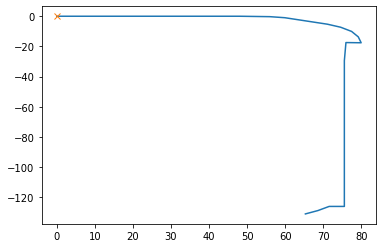

In [61]:
plt.plot(x_ori,y_ori)
plt.plot(x_ori[0],y_ori[0],marker='x')

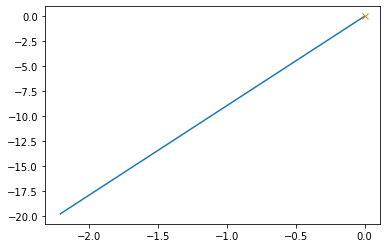

In [62]:
plt.plot(x_o,y_o)
plt.plot(x_o[0],y_o[0],marker='x')